In [1]:
import os
import sys
import json
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cycler import cycler
from IPython.core.display import HTML

from plot_utils import process_flower_logs, read_fedless_logs

### How to use

Download the latest zip file with all experiment artifacts from `https://fedless-experiment-artifacts.s3.eu-central-1.amazonaws.com/fedless-experiments-6aafd3e-1628697864.zip`, unzip it, and copy the absolute path to the `out` folder.

### Global Variables and Style Configuration

In [2]:
ROOT_OUT_DIR = Path("/Users/andreas/workspace/thesis-code/out/")
PLOT_OUTPUT_DIR = ROOT_OUT_DIR / "plots"
FLOWER_LOGS_DIR = ROOT_OUT_DIR / "flower-logs"

PLOT_OUTPUT_DIR.mkdir(exist_ok=True)

In [3]:
plt.style.use(['science', 'bright', 'ieee'])

In [4]:
flower_df = process_flower_logs(FLOWER_LOGS_DIR)
fedkeeper_df, fedkeeper_clients_df = read_fedless_logs(f"{ROOT_OUT_DIR}/fedkeeper*-*-*-*-*-*-*")
fedless_df, fedless_clients_df = read_fedless_logs(f"{ROOT_OUT_DIR}/fedless-[!d]*-*-*-*-*-*", ignore_dp=True, ignore_flower=True) # [!d] ignores DP experiments
fedless_dp_df, fedless_dp_clients_df = read_fedless_logs(f"{ROOT_OUT_DIR}/fedless-dp-*", ignore_dp=False, ignore_flower=True)
fedless_flower_df, fedless_flower_clients_df = read_fedless_logs(f"{ROOT_OUT_DIR}/fedless-flower-*", ignore_flower=False, ignore_dp=True)

Ignoring experiment folder /Users/andreas/workspace/thesis-code/out/fedless-flower-femnist-100-25-5-10-0001 because ignore_flower=True
Ignoring experiment folder /Users/andreas/workspace/thesis-code/out/fedless-flower-femnist-100-75-5-10-0001 because ignore_flower=True
Ignoring experiment folder /Users/andreas/workspace/thesis-code/out/fedless-flower-mnist-100-5-5-10-0001 because ignore_flower=True
Ignoring experiment folder /Users/andreas/workspace/thesis-code/out/fedless-flower-mnist-100-50-5-10-0001 because ignore_flower=True
Ignoring experiment folder /Users/andreas/workspace/thesis-code/out/fedless-flower-femnist-100-50-5-10-0001 because ignore_flower=True
Ignoring experiment folder /Users/andreas/workspace/thesis-code/out/fedless-flower-mnist-100-25-5-10-0001 because ignore_flower=True
Ignoring experiment folder /Users/andreas/workspace/thesis-code/out/fedless-flower-mnist-100-10-5-10-0001 because ignore_flower=True
Ignoring experiment folder /Users/andreas/workspace/thesis-code/

## FedLess on MNIST and LEAF

In [698]:
df_ = fedless_df.loc[("mnist", slice(1, 200), 200), :]
clients_df_ = fedless_clients_df.loc[("mnist", slice(1, 200), 200), :]
df_ = df_[df_["accuracy"] >= 0.99]
df_ = df_.groupby(["clients-round", "seed"]).min("round").groupby("clients-round").mean()["round"]
df_

clients-round
25     76.000000
100    84.333333
200    78.000000
Name: round, dtype: float64

<Figure size 1980x1500 with 0 Axes>

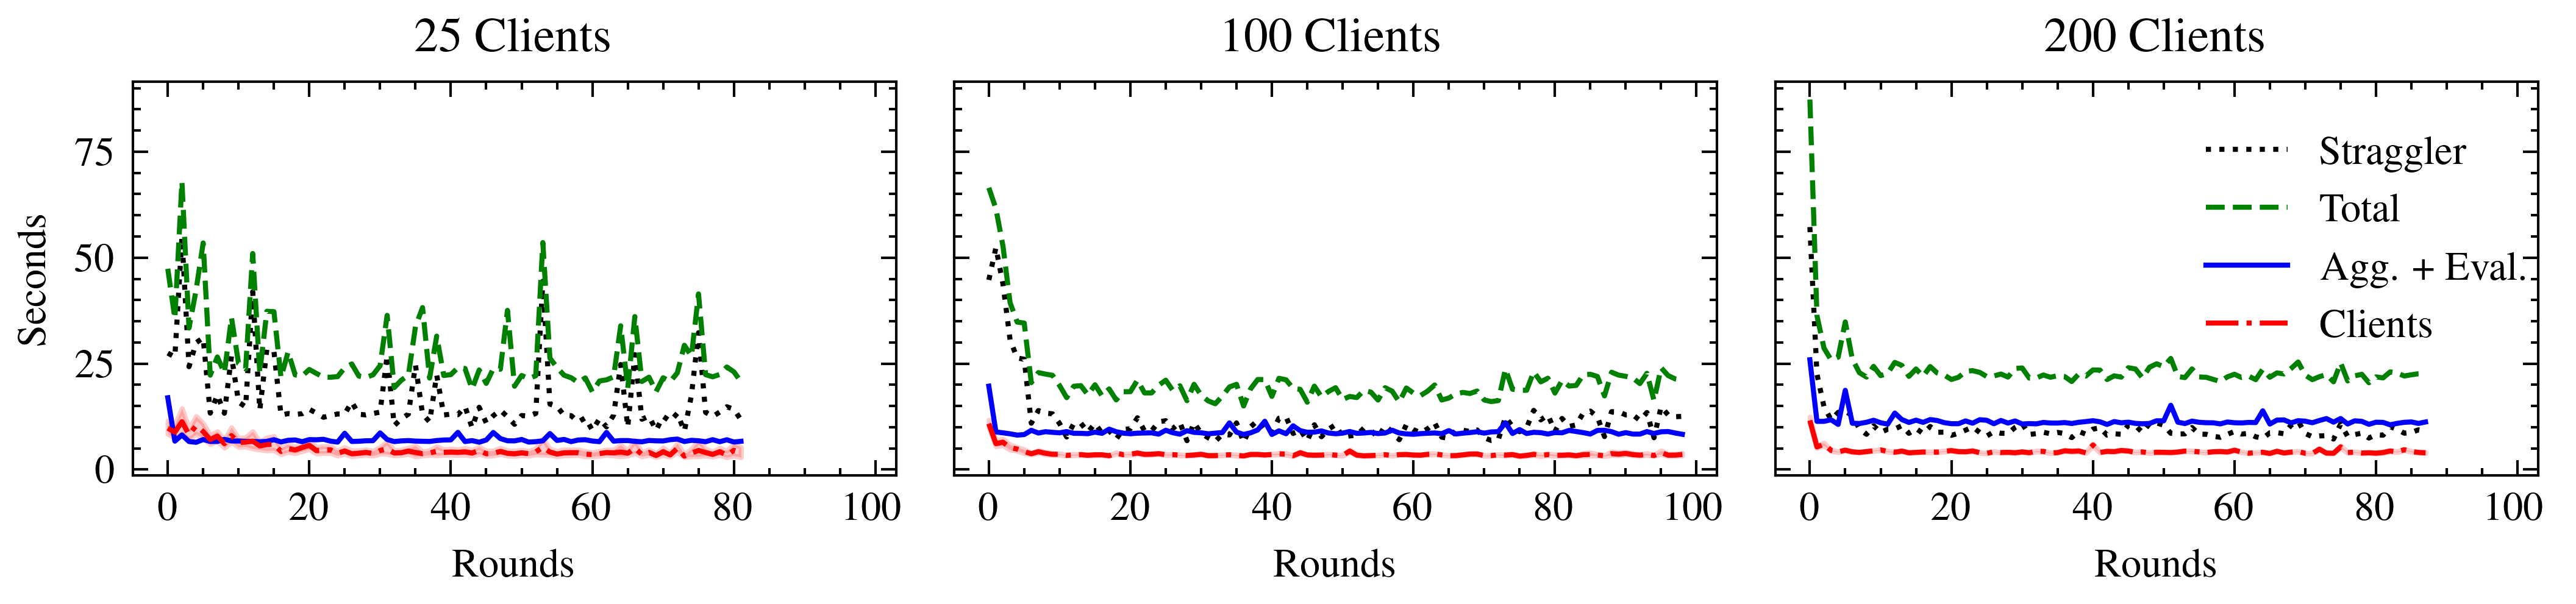

In [699]:
dataset = "mnist"
df_ = fedless_df.loc[(dataset, slice(1, 200), 200), :]
clients_df_ = fedless_clients_df.loc[(dataset, slice(1, 200), 200), :]#.reset_index()    
mean_maximum_client_per_round_df = clients_df_.groupby(["clients-round", "seed", "round"]).max("seconds").groupby(["clients-round", "round"]).mean()
mean_client_per_round_df = clients_df_.groupby(["clients-round", "round"]).mean()
mean_round_df = df_.groupby(["clients-round", "round"]).mean()

plt.clf()
fig, axarr = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(7.167, 7.167 / 4))
for i, clients in enumerate([25, 100, 200]):
    sns.lineplot(
        x="round",
        y="seconds",
        data=mean_maximum_client_per_round_df.loc[clients],
        ax=axarr[i],
        label="Straggler"
    )
    sns.lineplot(
        x="round",
        y="time",
        data=mean_round_df.loc[clients],
        ax=axarr[i],
        label="Total"
    )
    sns.lineplot(
        x="round",
        y="time-aggregation",
        data=mean_round_df.loc[clients],
        ax=axarr[i],
        label="Agg. + Eval."
    )
    sns.lineplot(
        x="round",
        y="seconds",
        data=clients_df_.loc[(dataset, clients)],
        ax=axarr[i],
        label="Clients",
        ci=95
    )
    axarr[i].set_title(f"{clients} Clients")
    axarr[i].set_xlabel("Rounds")
    axarr[i].set_ylabel("Seconds")
    axarr[i].get_legend().remove()
    
handles, labels = axarr[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.85, 0.4))
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-{dataset}-straggler-impact.pdf", bbox_inches ='tight',pad_inches=0)

<Figure size 1980x1500 with 0 Axes>

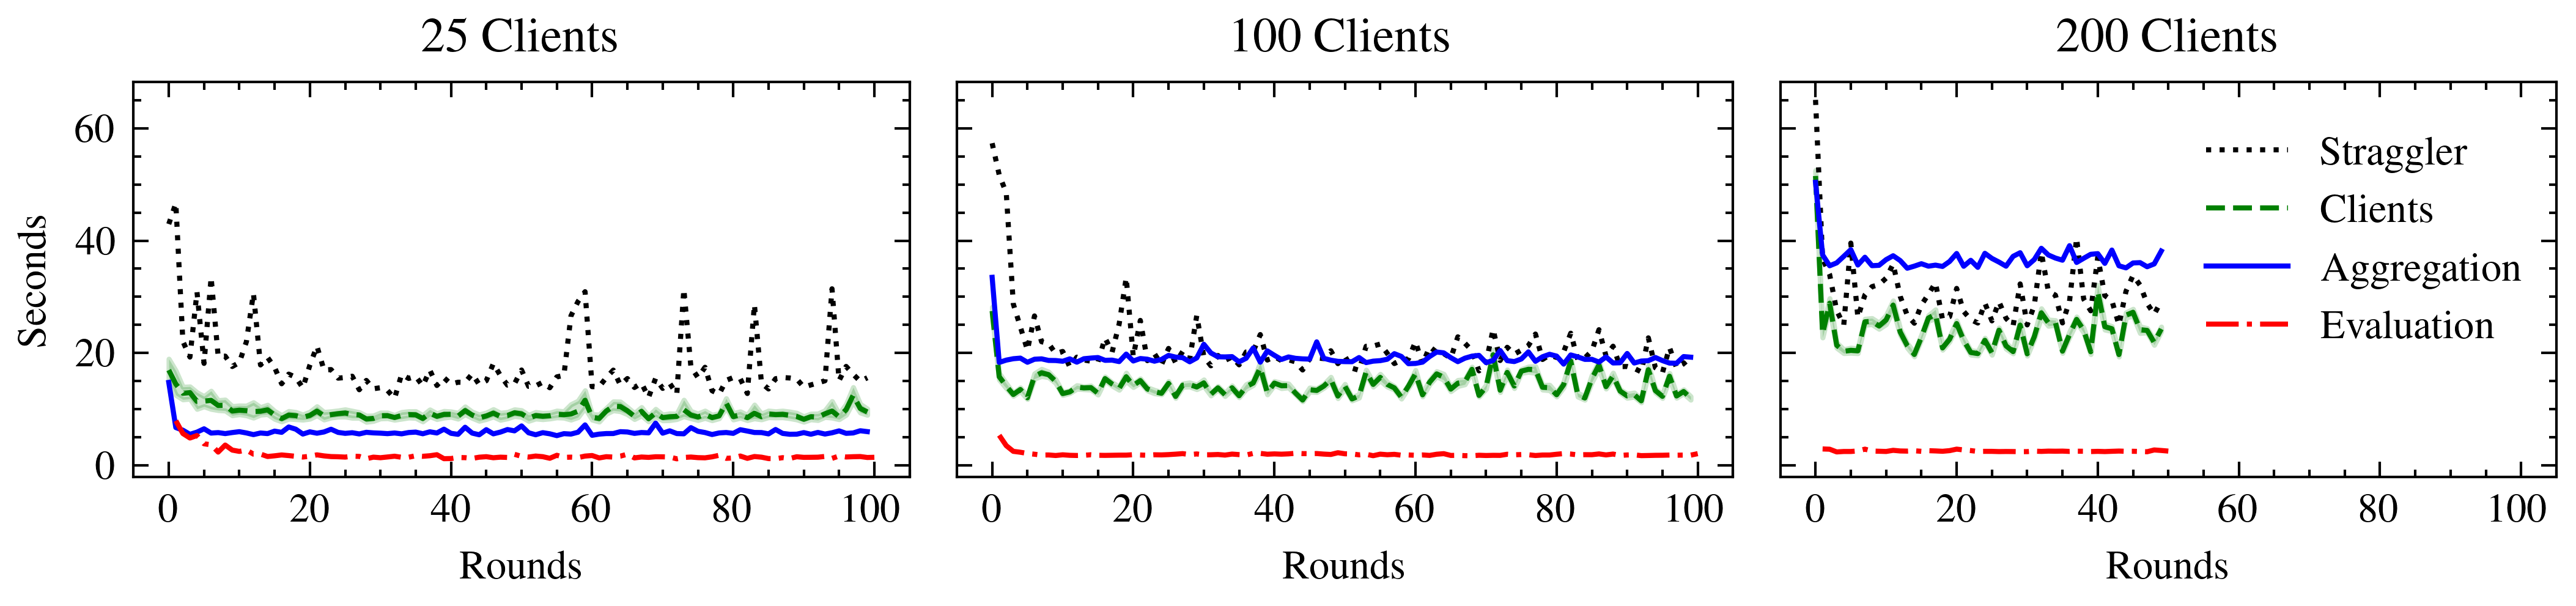

In [700]:
dataset = "femnist"
df_ = fedless_df.loc[(dataset, slice(1, 200), 200), :]
mean_round_df = df_.groupby(["clients-round", "round"]).mean()

clients_df_ = fedless_clients_df.loc[(dataset, slice(1, 200), 200), :]
clients_train_df_ = clients_df_[clients_df_["eval"] == False]
mean_maximum_client_per_round_df = clients_df_.groupby(["eval", "clients-round", "seed", "round"]).max("seconds").groupby(["eval", "clients-round", "round"]).mean()
mean_client_per_round_df = clients_df_.groupby(["eval", "clients-round", "round"]).mean()

plt.clf()
fig, axarr = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(7.167, 7.167 / 4))
for i, clients in enumerate([25, 100, 200]):
    sns.lineplot(
        x="round",
        y="seconds",
        data=mean_maximum_client_per_round_df.loc[(False, clients), :],
        ax=axarr[i],
        label="Straggler"
    )
    sns.lineplot(
        x="round",
        y="seconds",
        data=clients_train_df_.loc[(dataset, clients), :], # mean_client_per_round_df.loc[(False, clients), :],
        ax=axarr[i],
        label="Clients",
    )
    #sns.lineplot(
    #    x="round",
    #    y="time",
    #    data=mean_round_df.loc[clients],
    #    ax=axarr[i],
    #    label="Total"
    #)
    sns.lineplot(
        x="round",
        y="time-aggregation",
        data=mean_round_df.loc[clients],
        ax=axarr[i],
        label="Aggregation"
    )
    sns.lineplot(
        x="round",
        y="seconds",
        data=mean_client_per_round_df.loc[(True, clients), :],
        ax=axarr[i],
        label="Evaluation"
    )
    axarr[i].set_title(f"{clients} Clients")
    axarr[i].set_xlabel("Rounds")
    axarr[i].set_ylabel("Seconds")
    axarr[i].get_legend().remove()
    
handles, labels = axarr[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.85, 0.4))
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-{dataset}-straggler-impact.pdf", bbox_inches ='tight',pad_inches=0)

In [ ]:
dataset = "shakespeare"
df_ = fedless_df.loc[(dataset, slice(1, 200), 200), :]

clients_df_ = fedless_clients_df.loc[(dataset, slice(1, 200), 200), :]#.reset_index()    
clients_train_df_ = clients_df_[clients_df_["eval"] == False]
mean_maximum_client_per_round_df = clients_df_.groupby(["eval", "clients-round", "seed", "round"]).max("seconds").groupby(["eval", "clients-round", "round"]).mean()
mean_client_per_round_df = clients_df_.groupby(["eval", "clients-round", "round"]).mean()
mean_round_df = df_.groupby(["clients-round", "round"]).mean()

plt.clf()
fig, axarr = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(7.167 / 1.5, 7.167 / 4))
for i, clients in enumerate([10, 25]):
    sns.lineplot(
        x="round",
        y="seconds",
        data=mean_maximum_client_per_round_df.loc[(False, clients), :],
        ax=axarr[i],
        label="Straggler"
    )
    sns.lineplot(
        x="round",
        y="seconds",
        data=clients_train_df_.loc[(dataset, clients), :], # mean_client_per_round_df.loc[(False, clients), :],
        ax=axarr[i],
        label="Clients",
    )
    #sns.lineplot(
    #    x="round",
    #    y="time",
    #    data=mean_round_df.loc[clients],
    #    ax=axarr[i],
    #    label="Total"
    #)
    sns.lineplot(
        x="round",
        y="time-aggregation",
        data=mean_round_df.loc[clients],
        ax=axarr[i],
        label="Aggregation"
    )
    sns.lineplot(
        x="round",
        y="seconds",
        data=mean_client_per_round_df.loc[(True, clients), :],
        ax=axarr[i],
        label="Evaluation"
    )
    axarr[i].set_title(f"{clients} Clients")
    axarr[i].set_xlabel("Rounds")
    axarr[i].set_ylabel("Seconds")
    axarr[i].get_legend().remove()
    
handles, labels = axarr[-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()

fig.savefig(PLOT_OUTPUT_DIR / f"fedless-{dataset}-straggler-impact.pdf", bbox_inches ='tight',pad_inches=0, bbox_extra_artists=(lgd,))

<Figure size 1980x1500 with 0 Axes>

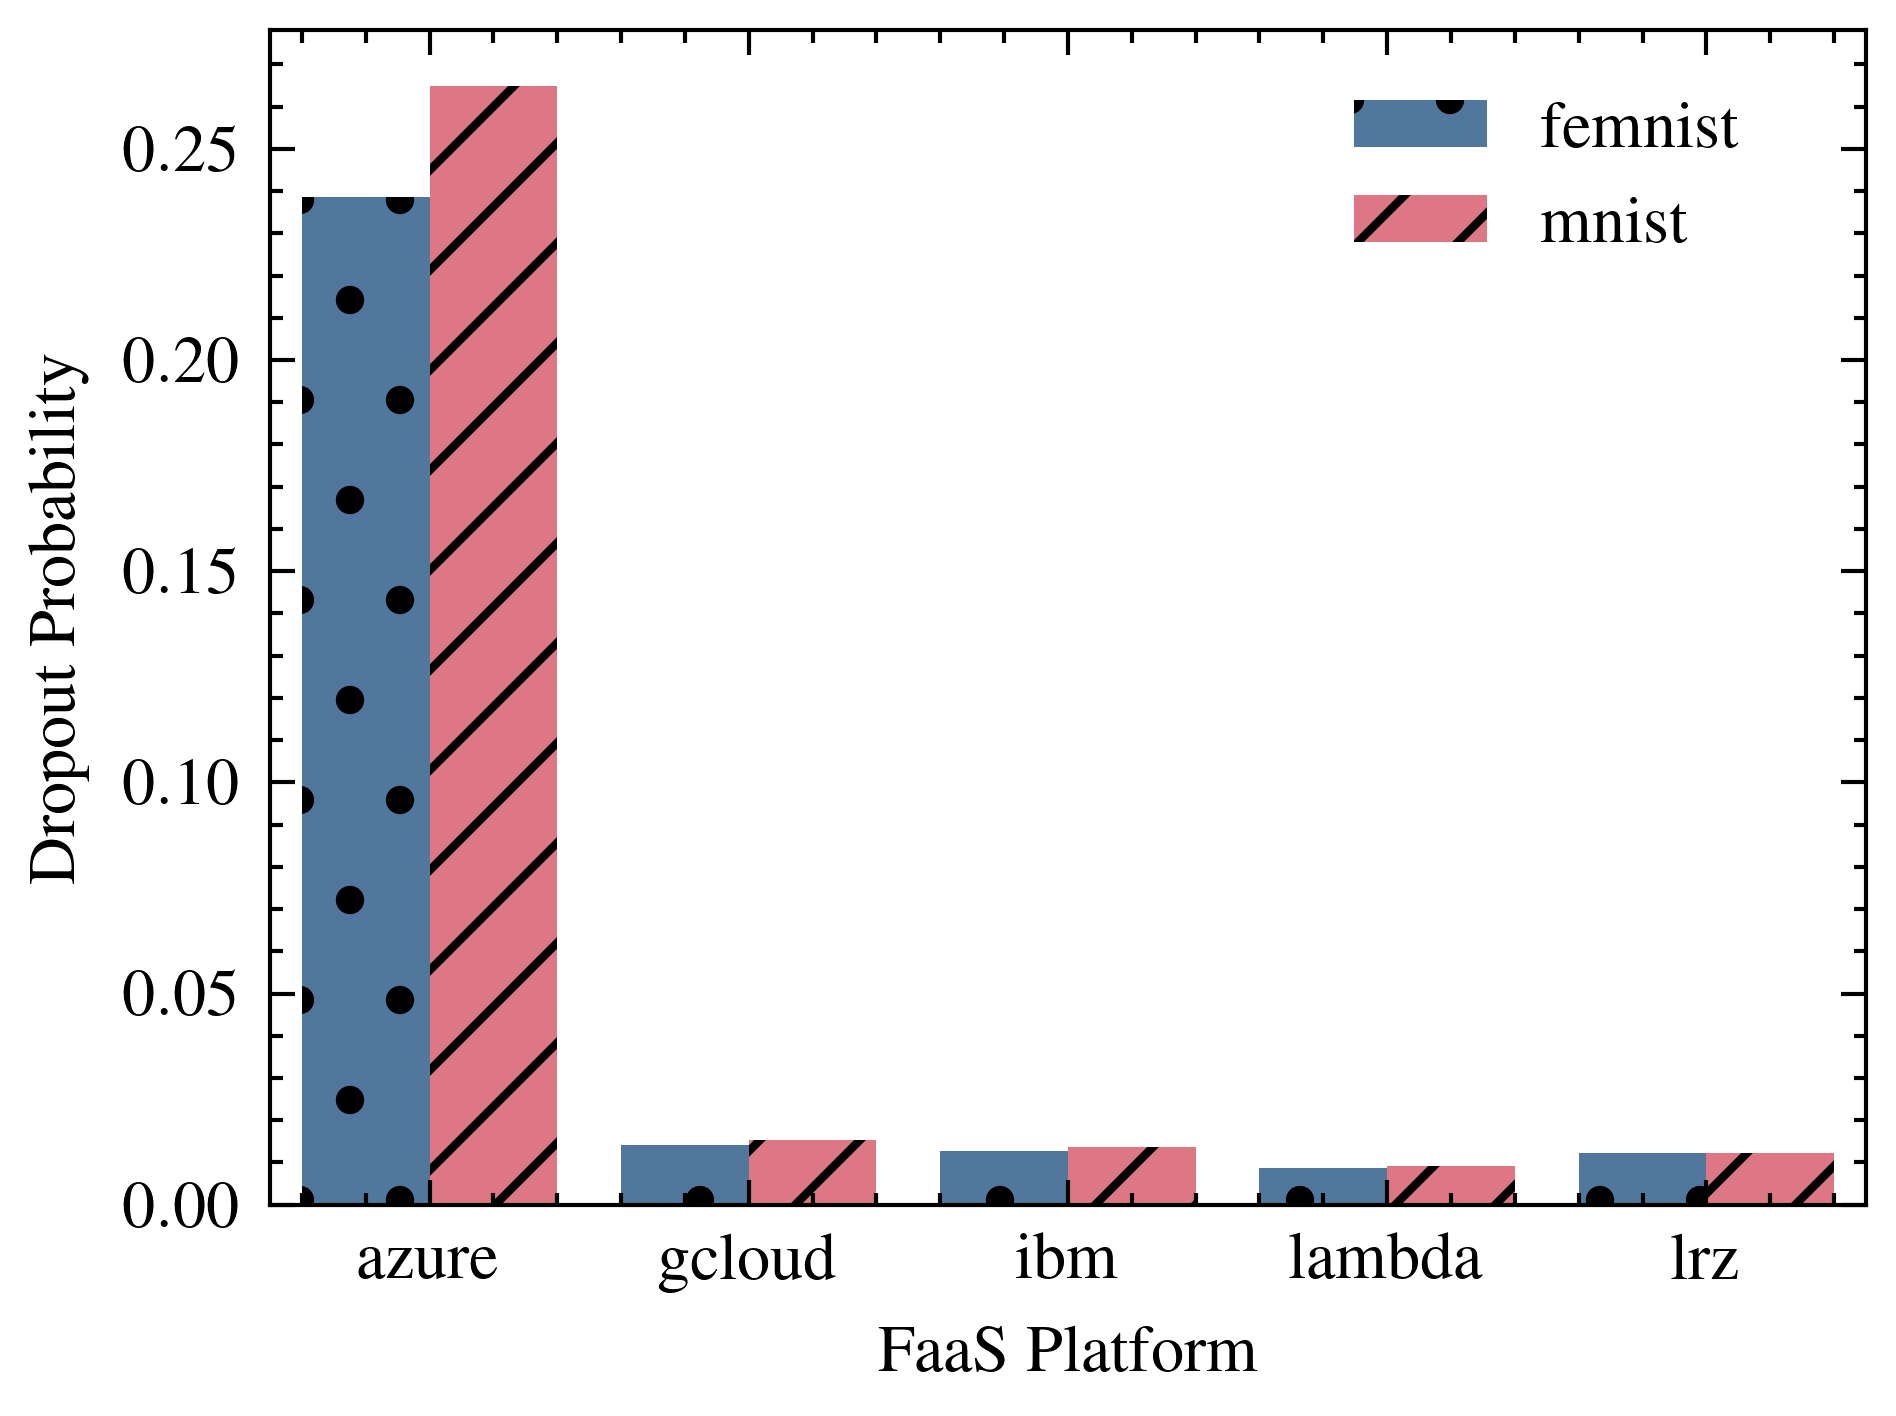

In [701]:
clients_df_ = fedless_clients_df.loc[(("mnist", "femnist"), slice(1, 200), 200), :].reset_index()
clients_df_ = clients_df_[clients_df_["eval"] == False]

df_ = (
    clients_df_.loc[clients_df_.groupby(["dataset", "seed", "round"]).idxmax()["seconds"], :].groupby("platform").size() / 
    clients_df_.groupby(["dataset", "platform"]).size()
).reset_index()
plt.clf()
with plt.style.context(['science', 'ieee', 'bright']):
    fig, ax = plt.subplots()
    sns.barplot(
        y=0,
        x="platform",
        hue="dataset",
        data=df_,
        ax=ax,
        #linewidth=1, 
        #facecolor=(1, 1, 1, 0),
        #errcolor=".2", 
        #edgecolor=".2"
    )

    num_locations = len(df_.platform.unique())
    hatches = itertools.cycle(['.', '//', '+', '-', 'x', '\\', '', 'o', 'O', '.'])
    for i, bar in enumerate(ax.patches):
        if i % num_locations == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)

    ax.set_xlabel("FaaS Platform")
    ax.set_ylabel("Dropout Probability")
    ax.get_legend().remove()
    fig.legend(loc=(0.7, 0.8))
    fig.tight_layout()
    fig.savefig(PLOT_OUTPUT_DIR / f"fedless-platforms-dropout-prob.pdf", bbox_inches ='tight',pad_inches=0)

<Figure size 1980x1500 with 0 Axes>

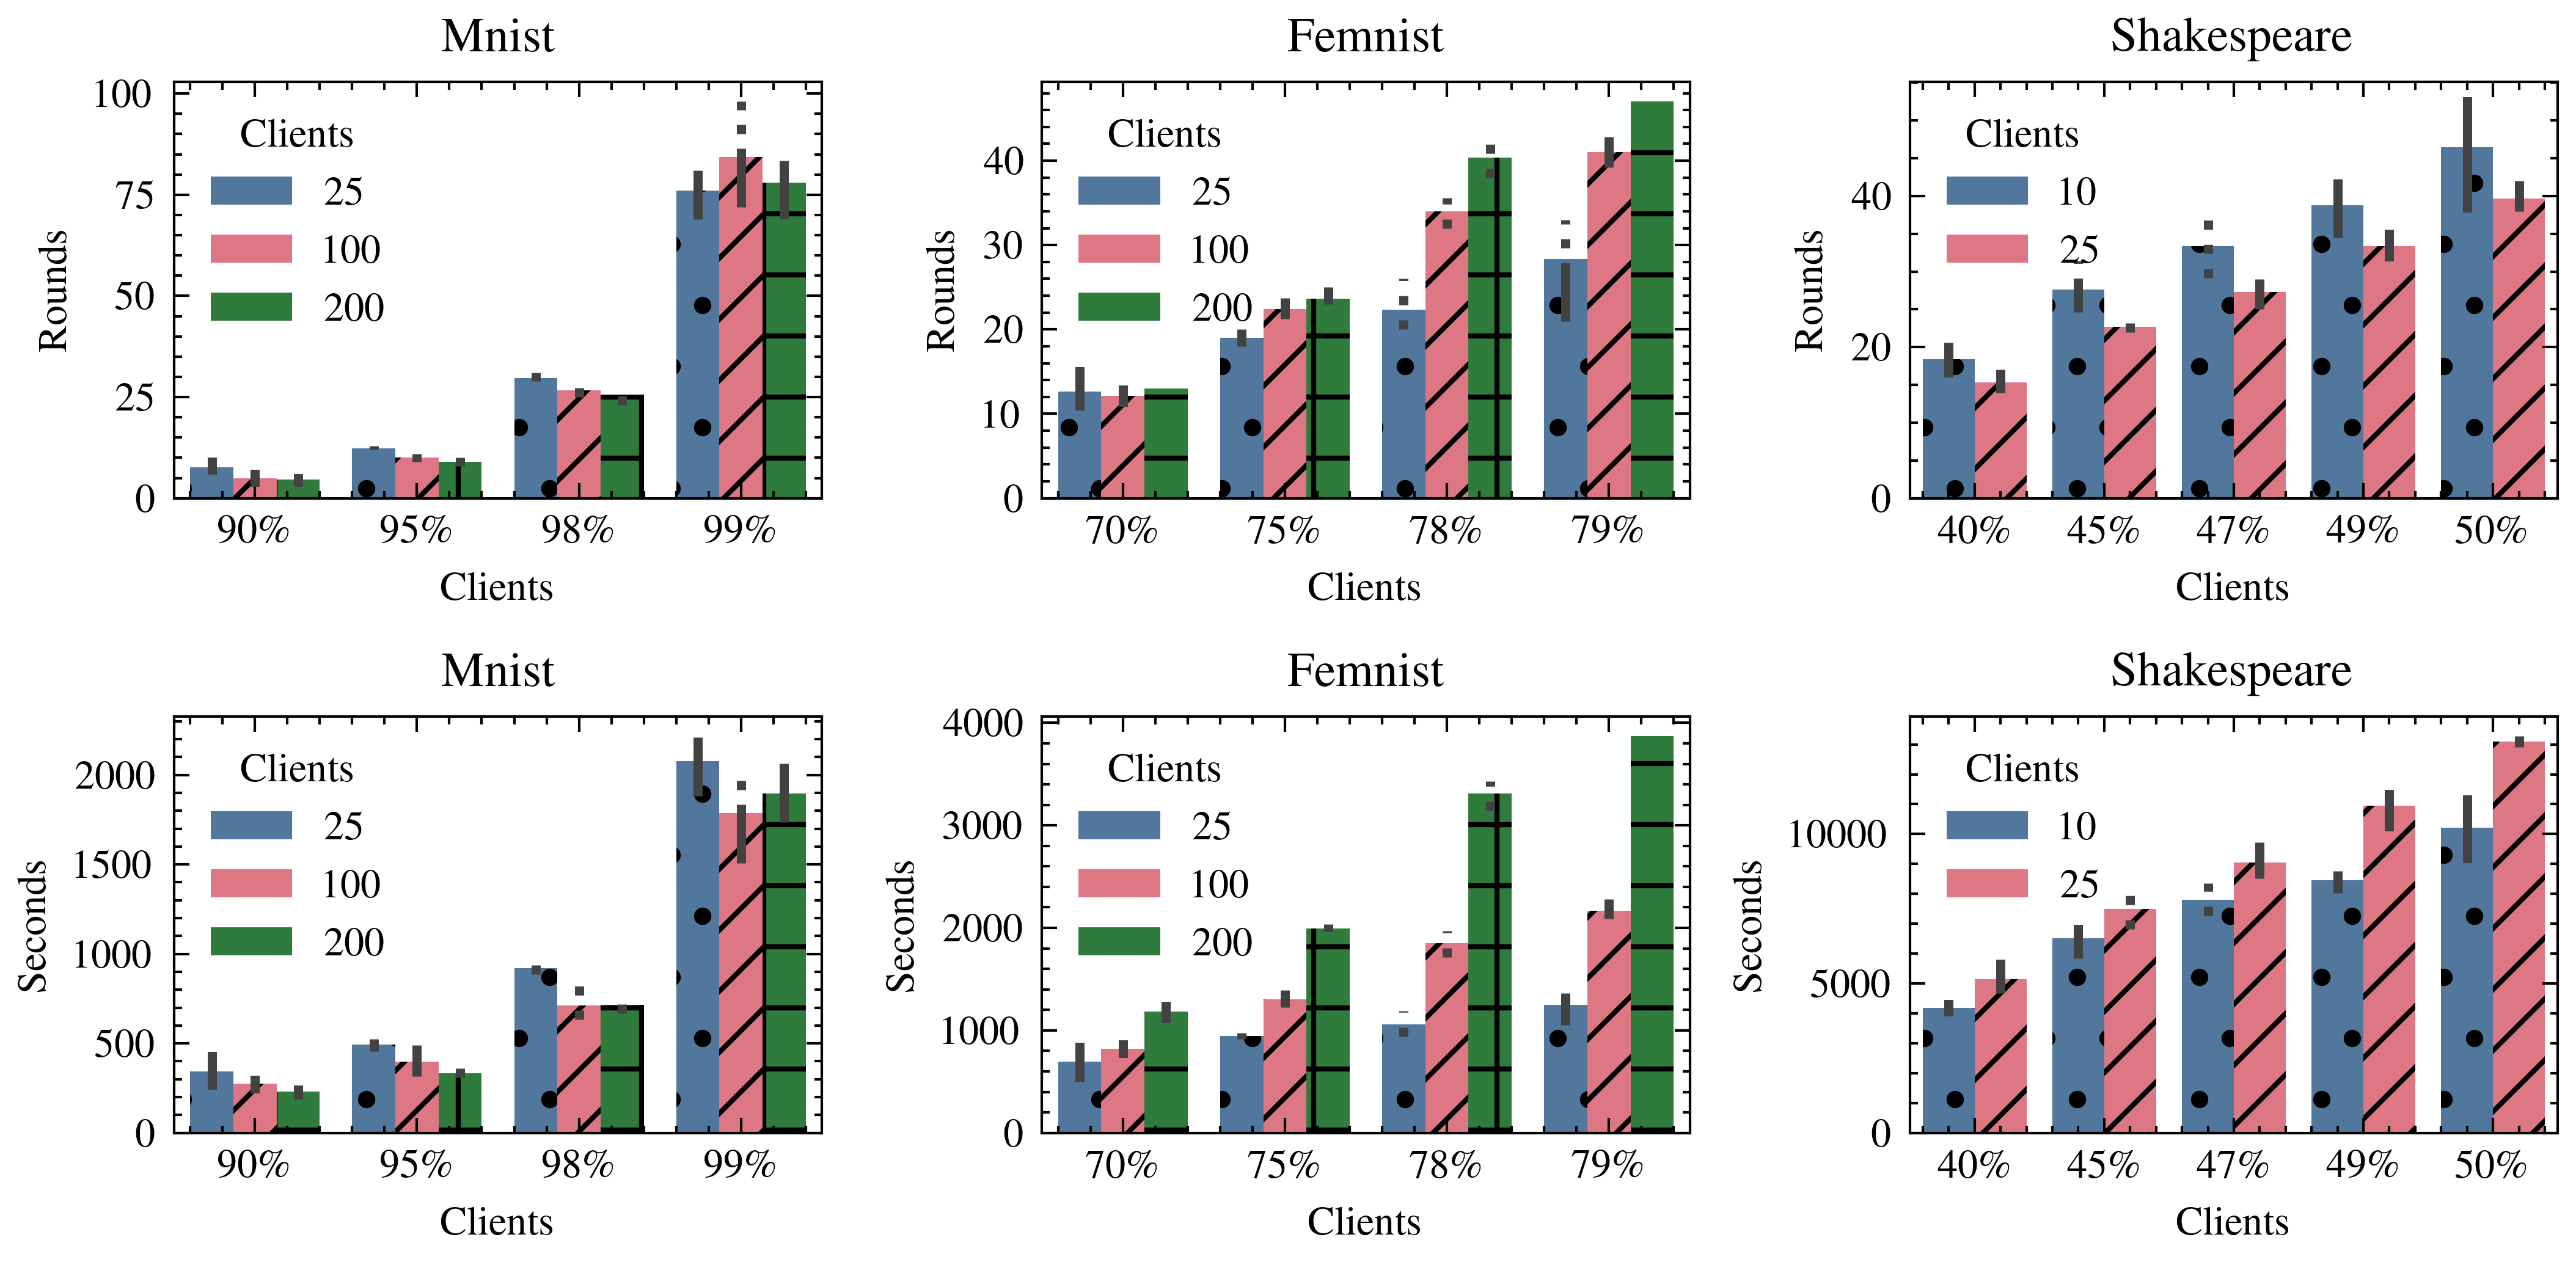

In [704]:
plt.clf()
fig, axarr = plt.subplots(nrows=2, ncols=3, sharex="col", figsize=(7.167, 7.167 / 2))

fedless_df_ = fedless_df.copy()
fedless_df_['time-total'] = fedless_df_.groupby(["dataset", "clients-round", "seed"])['time'].transform(pd.Series.cumsum)

with plt.style.context(['science', 'ieee', 'bright']):

    for i, (dataset, target_accuracies) in enumerate([
        ("mnist", [0.9, 0.95, 0.98, 0.99]),
        ("femnist", [0.7, 0.75, 0.78, 0.79]),
        ("shakespeare", [0.4, 0.45, 0.47, 0.49, 0.5])
        ]): #, "femnist", "shakespeare"]):
        dataset_df_ = fedless_df_.loc[(dataset, slice(1, 200), 200), :]
        dfs_ = []
        for acc in target_accuracies:
            df_ = dataset_df_.copy()
            df_ = df_[df_["accuracy"] >= acc]
            df_ = df_.groupby(["clients-round", "seed"]).min("round")
            dfs_.append(df_)
        df_ = pd.concat(dfs_, keys=[f"{int(t * 100)}\%" for t in target_accuracies], names=["target"]).reset_index()
        sns.barplot(
            x="target",
            y="round",
            hue="clients-round",
            data=df_,
            ax=axarr[0, i]
        )
        axarr[0, i].get_legend().set_title("Clients")
        axarr[0, i].set_xlabel("Clients")
        axarr[0, i].set_ylabel("Rounds")
        axarr[0, i].set_title(dataset.capitalize())
        axarr[0, i].xaxis.set_tick_params(which='both', labelbottom=True)



        num_locations = len(target_accuracies)
        hatches = itertools.cycle(['.', '//', '+', '-', 'x', '\\', '', 'o', 'O', '.'])
        for j, bar in enumerate(axarr[0, i].patches):
            if j % num_locations == 0:
                hatch = next(hatches)
            bar.set_hatch(hatch)

        sns.barplot(
            x="target",
            y="time-total",
            hue="clients-round",
            data=df_,
            ax=axarr[1, i]
        )
        axarr[1, i].get_legend().set_title("Clients")
        axarr[1, i].set_xlabel("Clients")
        axarr[1, i].set_ylabel("Seconds")
        axarr[1, i].set_title(dataset.capitalize())
        
        hatches = itertools.cycle(['.', '//', '+', '-', 'x', '\\', '', 'o', 'O', '.'])
        for j, bar in enumerate(axarr[1, i].patches):
            if j % num_locations == 0:
                hatch = next(hatches)
            bar.set_hatch(hatch)
            
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-convergence-rounds-and-time.pdf", bbox_inches ='tight', pad_inches=0)

In [ ]:
plt.clf()
fig, ax = plt.subplots() # nrows=2, ncols=3, sharex="col", figsize=(7.167, 7.167 / 2))

df_ = fedless_clients_df.reset_index()
df_ = df_[df_["clients-total"] == 200]
df_ = df_[df_["eval"] == False]
df_ = df_[df_["dataset"] != "shakespeare"]
df_["dataset"] = df_["dataset"].apply(str.capitalize)

sns.boxplot(
    x="dataset",
    y="seconds",
    hue="platform",
    data=df_,
    showfliers=False, # Mention in text that removed
    ax=ax
)

hatches = itertools.cycle(['//', 'o', '+', 'x', '-', '.', 'x', '\\', '', '', 'O', '.'][:5]) # ['.', '//', '+', '-', 'x', '\\', '', 'o', 'O', '.'])
for i, patch in enumerate(ax.artists + ax.patches):
    hatch = next(hatches)
    patch.set_hatch(hatch)
#    patch.set_height(22)

ax.get_legend().remove()
leg = fig.legend(loc=(0.744, 0.56))
for patch in leg.get_patches():
    patch.set_height(9)

    
ax.set_xlabel("FaaS Platform")
ax.set_ylabel("Function Duration (Seconds)")
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-platforms-durations.pdf", bbox_inches ='tight', pad_inches=0)

In [588]:
log_df = pd.read_csv(ROOT_OUT_DIR / "fedkeeper-fedless-gcloud-logs/downloaded-logs-20210811-151304-client-indep-secure-1-july-august.csv")
log_df = log_df[["labels.execution_id", "timestamp", "textPayload"]]
log_df["timestamp"] = pd.to_datetime(log_df["timestamp"])
log_df.rename(columns={"labels.execution_id": "execution_id"}, inplace=True)
log_df.set_index(["execution_id", "timestamp"], inplace=True)
log_df.sort_index(inplace=True)

log_events = [
        ("load-model", ("Loading model from database", "Model successfully loaded")),
        ("training", ("Running training", "Serializing model parameters")),
        ("model-serialization", ("Serializing model parameters", "Finished serializing mode")),
        ("store-model", ("Storing client results", "Finished writing to")),
        ("compile-model", ("Compiling model", "Running training")),
        ("load-data", ("Loading dataset...", "Finished loading dataset....")),
        #("token-verification-warm", ("Function execution started", "handler called for session...")),
        #("token-verification-cold", ("Did not find public keys, fetchin", "handler called for session...")),
        #("cache-hit", "INFO:fedless.cache:Cache Hit"),
        #("cache-miss", "INFO:fedless.cache:Cache Miss")
]

records = []
for name, group_df in log_df.groupby(["execution_id"]):
    try:
       
        tmp_ = {}
        for (event, (event_messages)) in log_events:
            if isinstance(event_messages, str):
                event_message = event_messages
                is_registered = not (group_df[group_df["textPayload"].str.contains(event_message)].empty)
                
                tmp_.update({
                    event: is_registered
                })
                
            else:
                try:
                    event_start, event_finish = event_messages
                    start_ts = group_df[group_df["textPayload"].str.contains(event_start)].index[0][1]
                    end_ts = group_df[group_df["textPayload"].str.contains(event_finish)].index[0][1]
                    seconds = (end_ts - start_ts).total_seconds()
                except IndexError as e:
                    if "token-verification" in event:
                        seconds = 0.0
                    else:
                        raise e
                    
                    
                tmp_.update({
                    event: seconds
                })
                
                
        model_size = group_df[group_df["textPayload"].str.contains("Serialized parameters:")].iloc[0].apply(lambda x: int(x.split(" ")[-2])).values[0]
        #client_id = group_df[group_df["textPayload"].str.contains("client_id=")].iloc[0].apply(lambda x: str(x.split("=")[-1])).values[0]
        model = { 2330095: "mnist", 26416831: "femnist", 3275841: "shakespeare"}.get(model_size)
            
        records.append({
            "execution_id": name,
            "model-size": model_size,
            "model": model,
            #"client-id": client_id,
            **tmp_
        })
    except IndexError as e:
        pass
fl_timing_details_df = pd.DataFrame.from_records(records).set_index("execution_id")
fl_timing_details_df

,model-size,model,load-model,training,model-serialization,store-model,compile-model,load-data
execution_id,,,,,,,,
0octa11zfulp,3275841,shakespeare,0.239,14.429,0.014,0.320,0.006,0.000
0octv0fommgq,6549449,None,0.309,12.025,0.019,0.320,0.006,0.237
0oo1sban30p8,6549449,None,0.336,10.788,0.016,0.324,0.008,0.240
0rt571iq9qdw,26416831,femnist,0.887,4.052,0.161,32.602,0.007,0.715
0rt5ezhg73uv,26416831,femnist,1.065,4.376,0.095,25.445,0.006,0.001
...,...,...,...,...,...,...,...,...
zjhiznpp7wmd,2330095,mnist,0.229,2.562,0.016,0.301,0.006,0.000
zjhiztylcmki,2330095,mnist,0.268,2.181,0.031,0.339,0.006,0.000
zr6oxratu8gl,3275841,shakespeare,0.262,13.533,0.015,0.322,0.004,0.000


<Figure size 1980x1500 with 0 Axes>

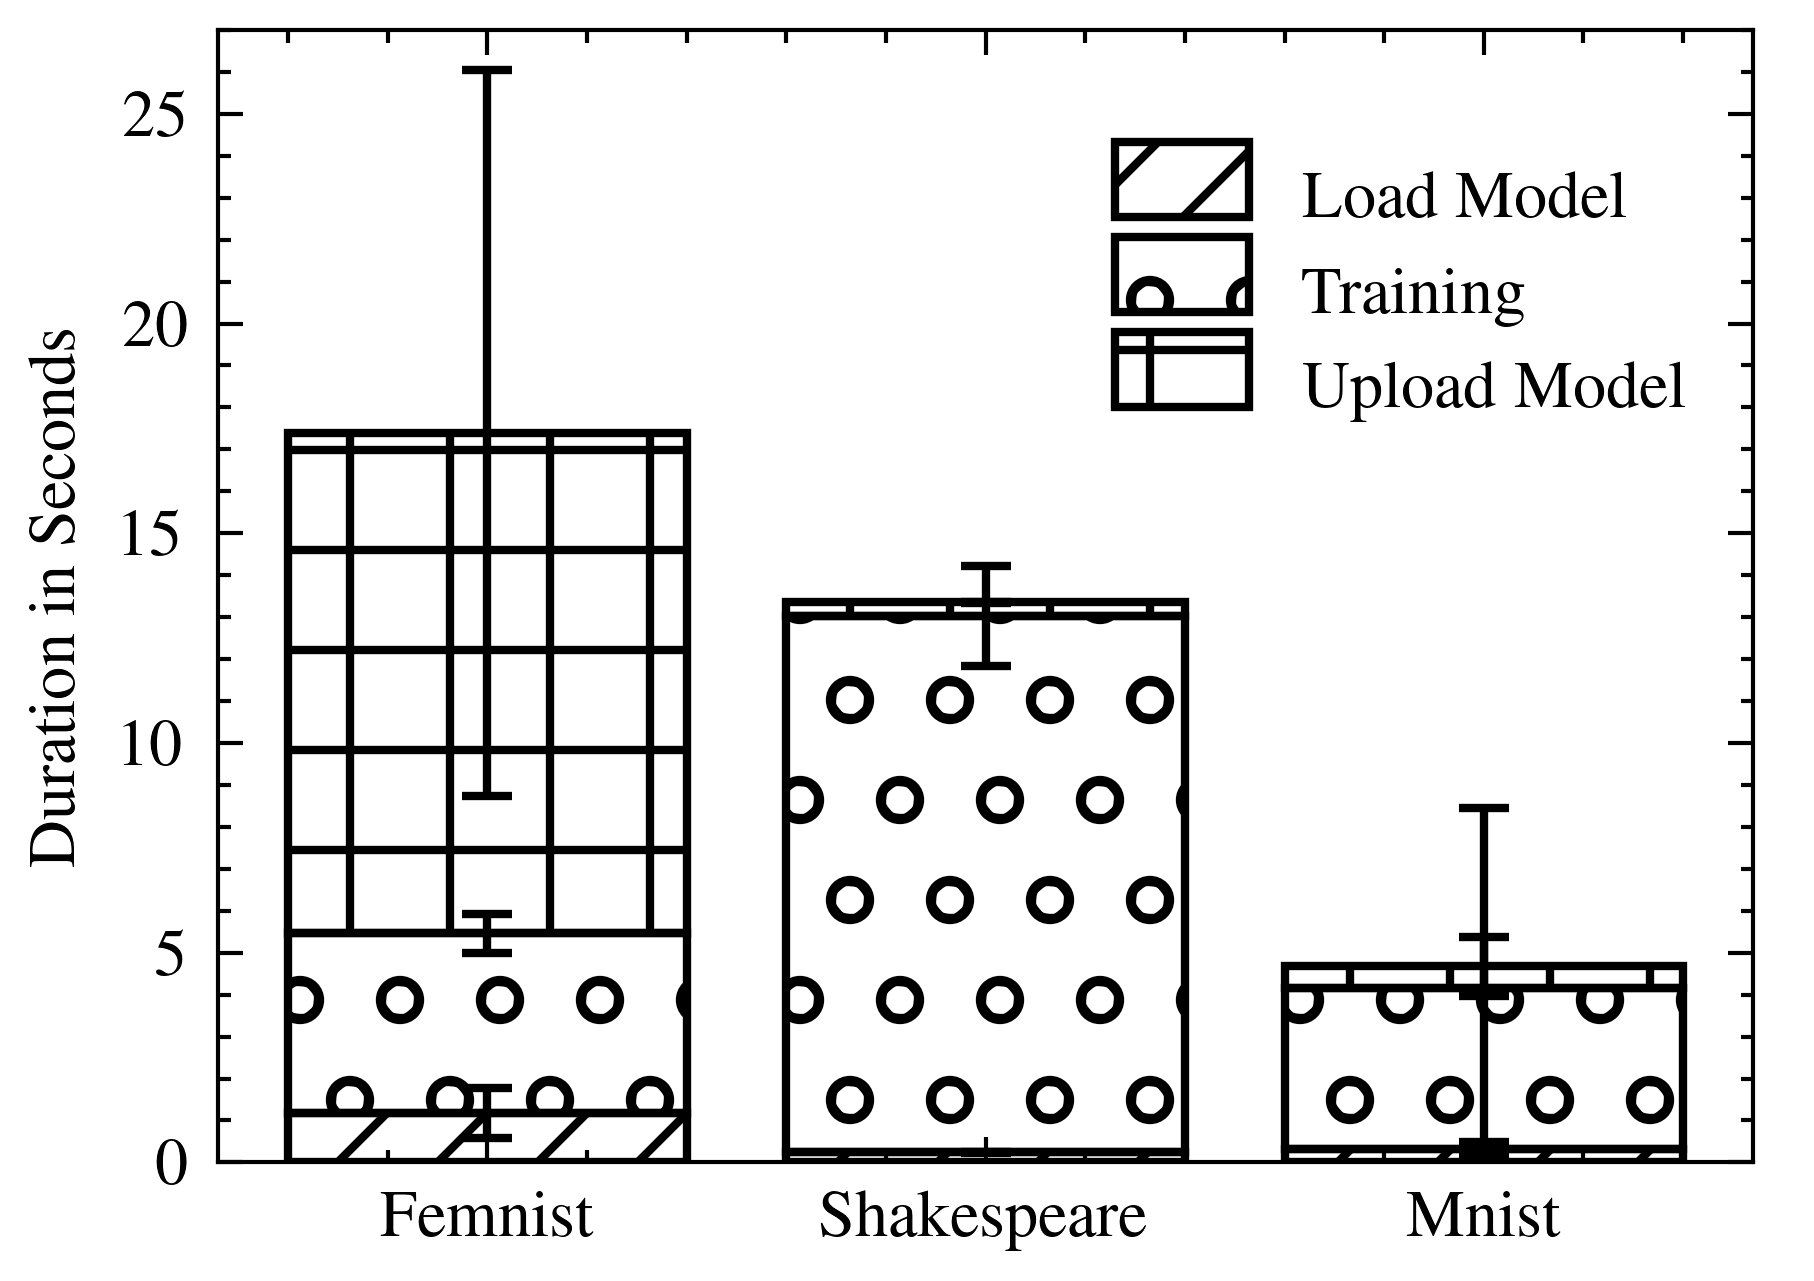

In [589]:
df_ = fl_timing_details_df

grouped_df = df_.groupby(["model"]) # "model", 
grouped_mean = grouped_df.mean()
grouped_std = grouped_df.std()
grouped_mean_femnist = grouped_mean.loc["femnist"]
grouped_std_femnist = grouped_std.loc["femnist"]
grouped_mean_shakespeare = grouped_mean.loc["shakespeare"]
grouped_std_shakespeare = grouped_std.loc["shakespeare"]
grouped_mean_mnist = grouped_mean.loc["mnist"]
grouped_std_mnist = grouped_std.loc["mnist"]


plt.clf()
fig, ax = plt.subplots() #, figsize=(12, 10))# plot bars # figsize=(7.167 /, 7.167 / 4)

bottom_fm, bottom_sh, bottom_mn = None, None, None
events = ["load-model", "training", "store-model"]
event_names = ["Load Model", "Training", "Upload Model"]
colors = ["tab:blue", "tab:green", "tab:red", "tab:purple", "tab:orange"]
hatches = itertools.cycle(['//', 'o', '+', 'x', '-', '.', 'x', '\\', '', '', 'O', '.'])
for event, event_name, color in zip(events, event_names, colors):
    hatch = next(hatches)
    vals_fm = grouped_mean_femnist[event]
    ax.bar(
        x=0,
        height=vals_fm,
        yerr=grouped_std_femnist[event],
        label=event_name,
        bottom=bottom_fm,
        color=color,
        hatch=hatch,
        fill=False,
        capsize=3.0
    )
    bottom_fm = bottom_fm or 0
    bottom_fm += vals_fm
    
    vals_sh = grouped_mean_shakespeare[event]
    ax.bar(
        x=1,
        height=vals_sh,
        yerr=grouped_std_shakespeare[event],
        bottom=bottom_sh,
        color=color,
        hatch=hatch,
        fill=False,
        capsize=3.0
    )
    bottom_sh = bottom_sh or 0
    bottom_sh += vals_sh
    
    vals_mn = grouped_mean_mnist[event]
    ax.bar(
        x=2,
        height=vals_mn,
        yerr=grouped_std_mnist[event],
        bottom=bottom_mn,
        color=color,
        hatch=hatch,
        fill=False,
        capsize=3.0
    )
    bottom_mn = bottom_mn or 0
    bottom_mn += vals_mn

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["Femnist", "Shakespeare", "Mnist"])
#ax.set_xscale('linear')
ax.set_ylabel('Duration in Seconds')
leg = fig.legend(loc=(0.6, 0.65))
for patch in leg.get_patches():
    patch.set_height(9)
ax.set_ylim(0.0, 27.0)
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-gcloud-timings.pdf" ,bbox_inches = 'tight',pad_inches = 0,  dpi=300)

<Figure size 1980x1500 with 0 Axes>

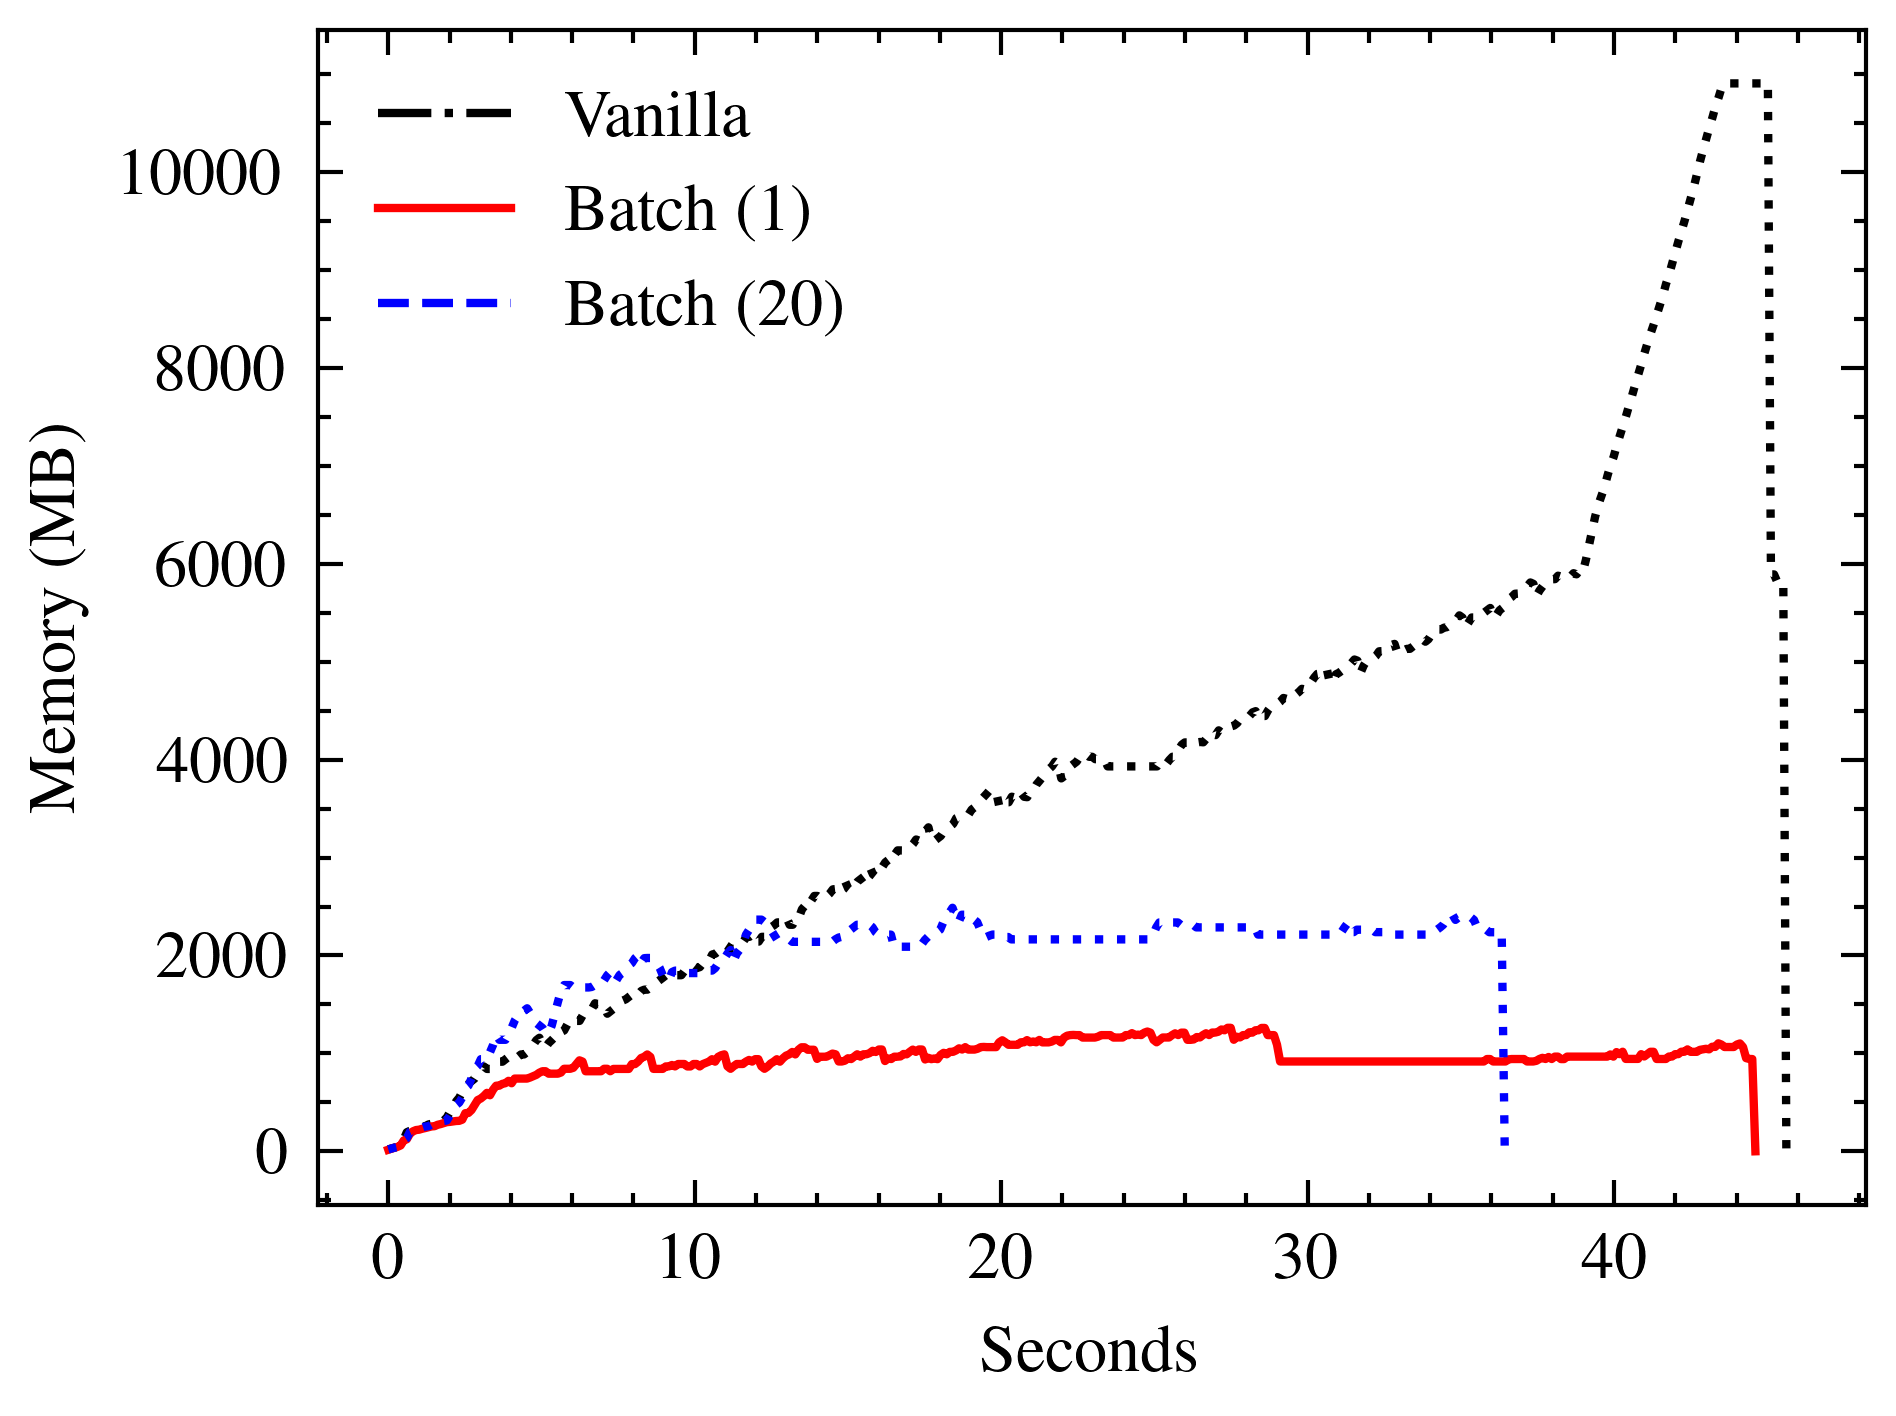

In [11]:
import datetime
aggregator_log_dir = ROOT_OUT_DIR / "aggregation"

df = pd.concat([
    pd.read_csv(aggregator_log_dir / "vanilla.dat", skiprows=2, sep=" ", header=None, usecols=[1, 2]).set_index(2),
    pd.read_csv(aggregator_log_dir / "stream-1.dat", skiprows=2, sep=" ", header=None, usecols=[1, 2]).set_index(2),
    pd.read_csv(aggregator_log_dir / "stream-20.dat", skiprows=2, sep=" ", header=None, usecols=[1, 2]).set_index(2),
], keys=["Vanilla", "Batch (1)", "Batch (20)"], names=["version"]).reset_index()
df.columns = ["version", "time", "memory"]
df["time"] = df["time"].apply(datetime.datetime.utcfromtimestamp)

df["timedelta"] = df.reset_index().groupby("version")["time"].transform(lambda x: (x - x.min()))
df["seconds"] = df["timedelta"].apply(lambda x: x.total_seconds())

plt.clf()
fig, ax = plt.subplots()
sns.lineplot(x="seconds", y="memory", data=df, hue="version", ax=ax)
ax.set_xlabel("Seconds")
ax.set_ylabel("Memory (MB)")
ax.get_legend().set_title("")
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"running-average-aggregator-new.pdf" ,bbox_inches = 'tight',pad_inches = 0)

## MNIST with Privacy

<Figure size 1980x1500 with 0 Axes>

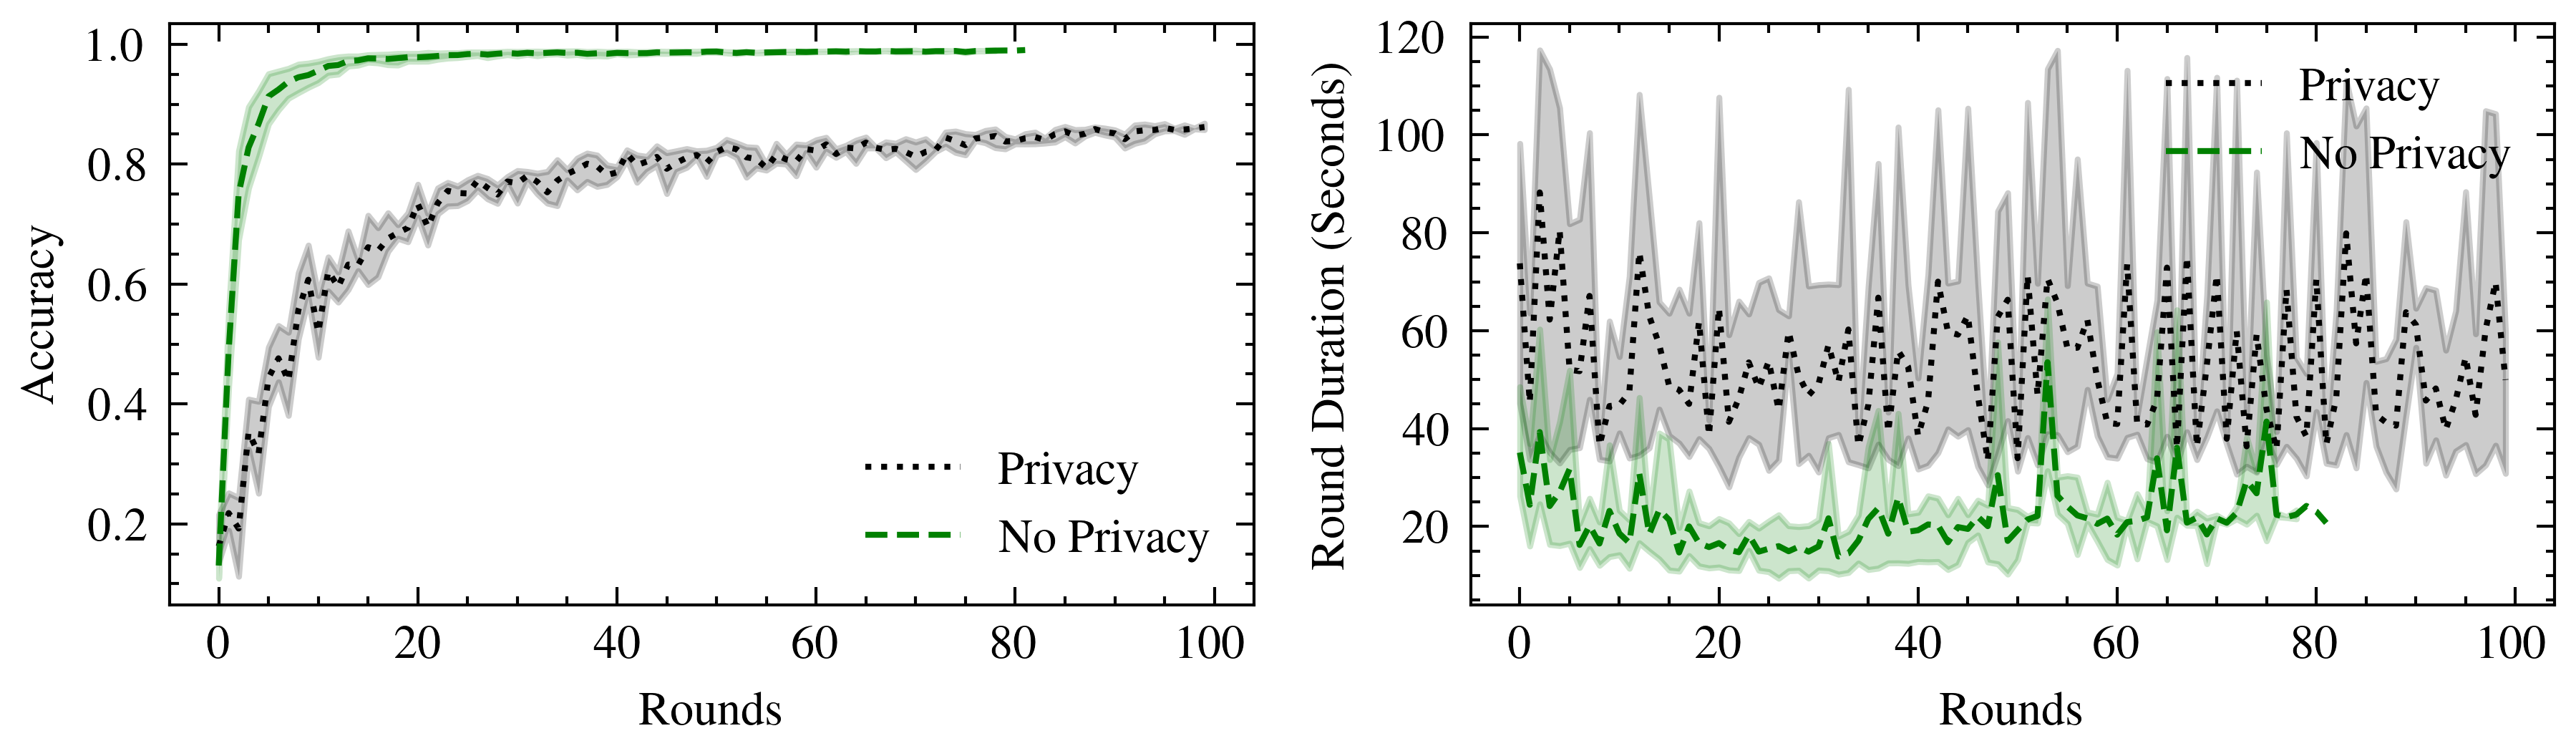

In [12]:
plt.clf()

fig, axarr = plt.subplots(ncols=2, figsize=(7.167, 7.167 / 4), sharex=True)

sns.lineplot(x="round", y="accuracy", data=fedless_dp_df.loc[("mnist", 25), :], ax=axarr[0], label="Privacy")
sns.lineplot(x="round", y="accuracy", data=fedless_df.loc[("mnist", 25), :], ax=axarr[0], label="No Privacy")

sns.lineplot(x="round", y="time", data=fedless_dp_df.loc[("mnist", 25), :], ax=axarr[1], label="Privacy")
sns.lineplot(x="round", y="time", data=fedless_df.loc[("mnist", 25), :], ax=axarr[1], label="No Privacy")

axarr[0].set_xlabel("Rounds")
axarr[1].set_xlabel("Rounds")

axarr[0].set_ylabel("Accuracy")
axarr[1].set_ylabel("Round Duration (Seconds)")

fig.savefig(PLOT_OUTPUT_DIR / f"fedless-privacy.pdf", bbox_inches = 'tight', pad_inches = 0)

## FedKeeper vs FedLess

FedLess: 4.5466+-1.24303939025048ms
FedKeeper (Opt.): 3.914878787878788+-0.27050925683771787ms
FedKeeper (Orig.): 5.6882666666666655+-2.769687141577948ms
Mean Difference of Optimized vs Unoptimized FedKeeper: 1.7733878787878776


<Figure size 1980x1500 with 0 Axes>

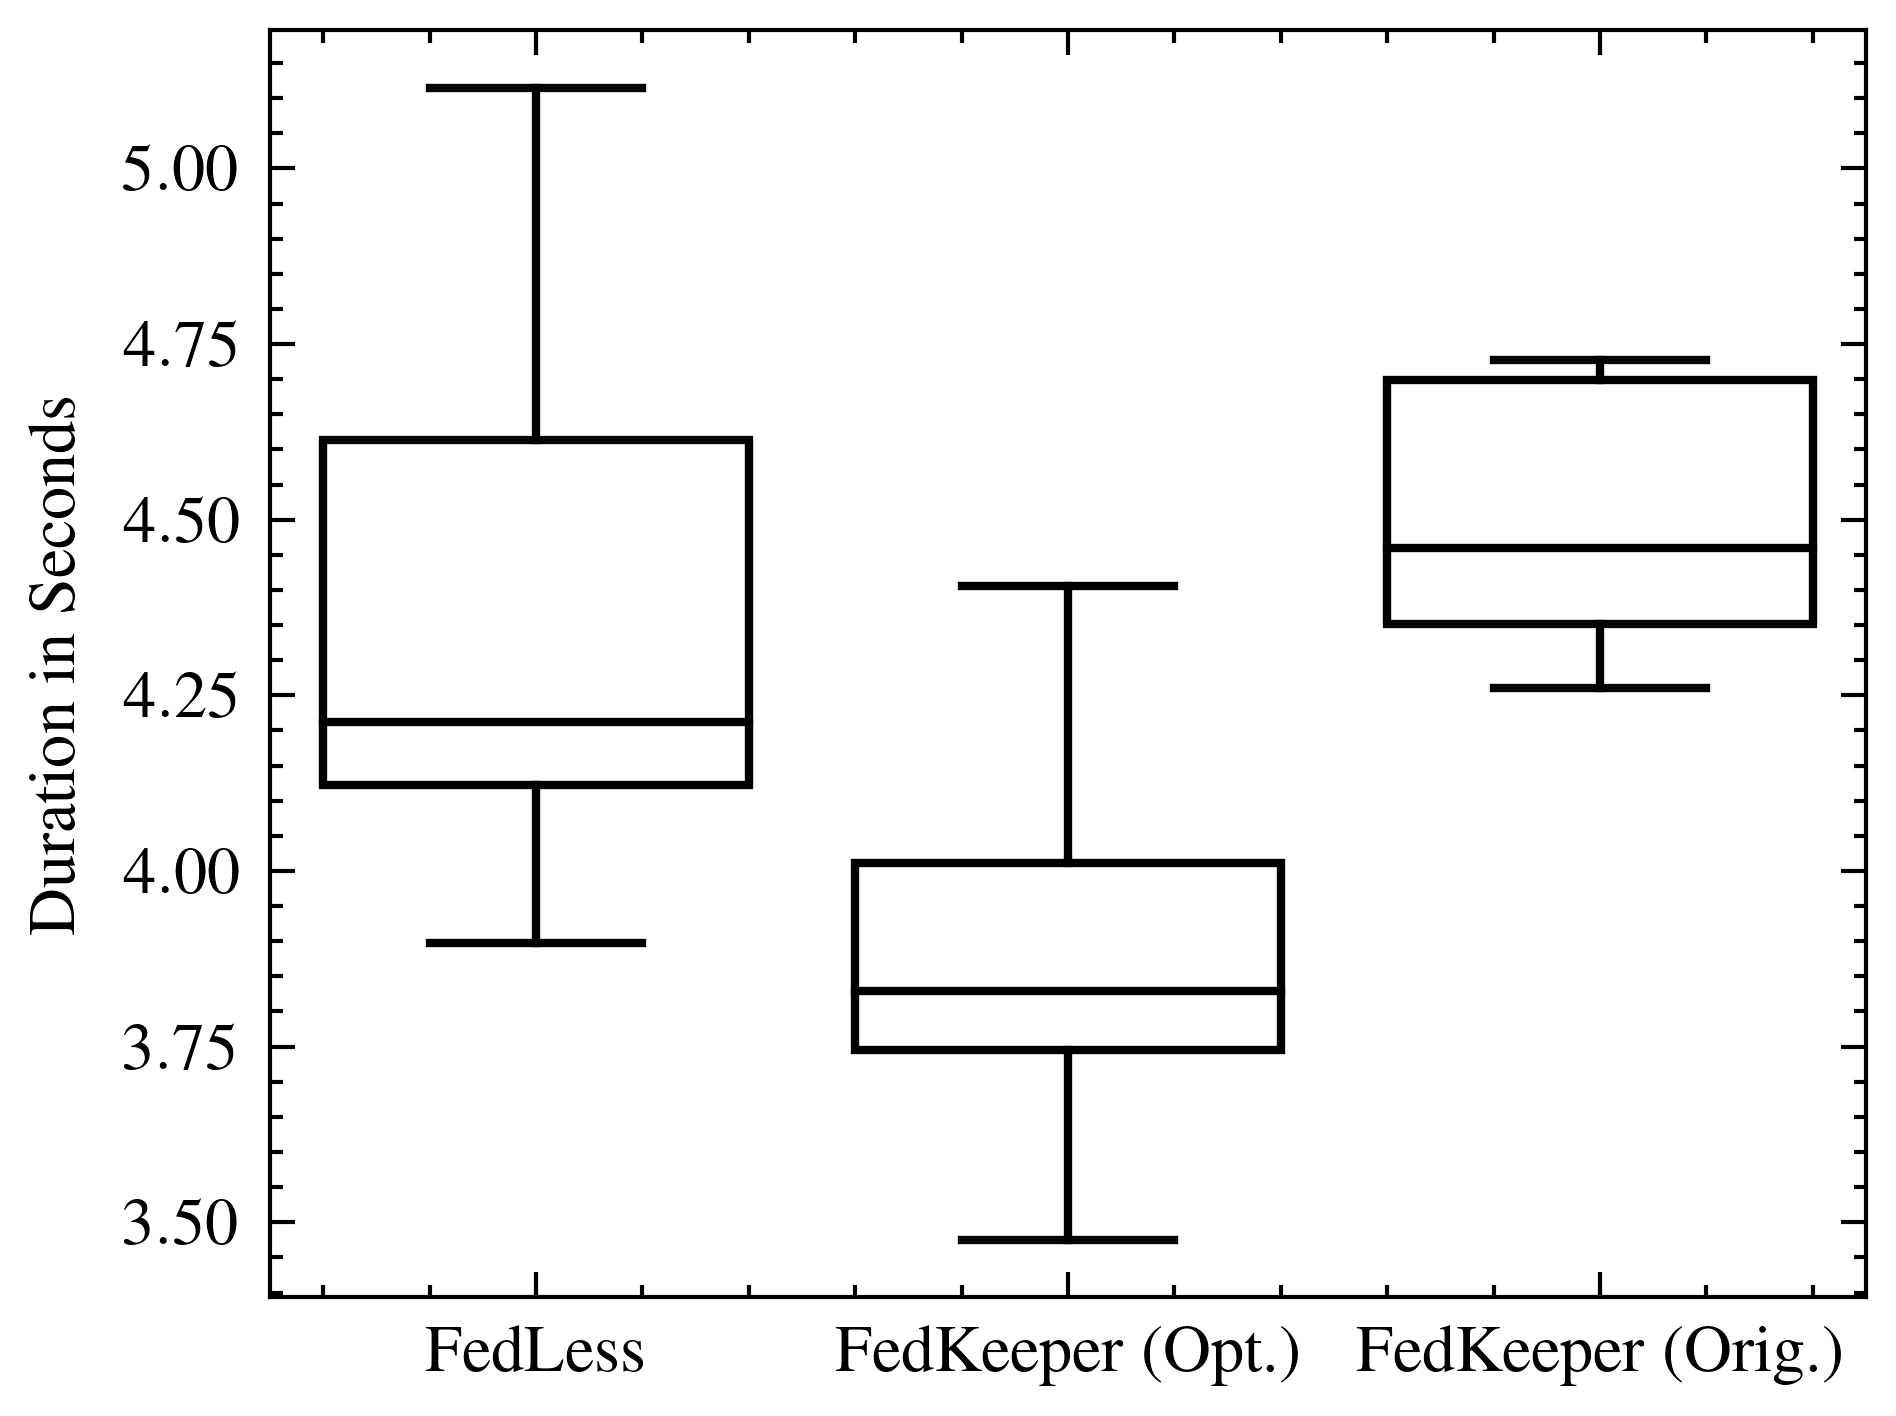

In [883]:
fedkeeper_gcloud_client_1_log_df = pd.read_csv(ROOT_OUT_DIR / "fedkeeper-fedless-gcloud-logs/downloaded-logs-20210805-181515-http-1.csv")
fedless_gcloud_client_1_log_df = pd.read_csv(ROOT_OUT_DIR / "fedkeeper-fedless-gcloud-logs/downloaded-logs-20210805-181149-client-indep-1.csv")
fedkeeper_uncached_gcloud_clientlog_df = pd.read_csv(ROOT_OUT_DIR / "fedkeeper-fedless-gcloud-logs/downloaded-logs-20210806-152324-client-no-caching.csv")


# GCloud Client Functions runtime based on >30 rounds of 1 client each with same hyperparameters
vals = []
for method, df in [("FedLess", fedless_gcloud_client_1_log_df), ("FedKeeper (Opt.)", fedkeeper_gcloud_client_1_log_df), ("FedKeeper (Orig.)", fedkeeper_uncached_gcloud_clientlog_df)]:
    log_statements  = df[df['textPayload'].astype(str).str.contains("Function execution took ")].textPayload
    timings = np.array([float(line[len("Function execution took "):].split(' ')[0]) for line in log_statements]) / 1000
    vals.append((method, timings))
    print(f"{method}: {timings.mean()}+-{timings.std()}ms")

df = pd.concat([pd.Series(timings) for _, timings in vals], keys=[m for m, _ in vals], names=["method"]).to_frame().reset_index()
fedkeeper_optimization_mean_difference = (df[df["method"] == "FedKeeper (Orig.)"].mean() - df[df["method"] == "FedKeeper (Opt.)"].mean())[0]    
print(f"Mean Difference of Optimized vs Unoptimized FedKeeper: {fedkeeper_optimization_mean_difference}")

plt.clf()
fig, ax = plt.subplots()
sns.boxplot(x="method", y=0, data=df, ax=ax, showfliers=False, color='white') # showfliers=False => WARM STARTS 
ax.set_xlabel("")
ax.set_ylabel("Duration in Seconds")
fig.tight_layout()

# iterate over boxes
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         ax.lines[j].set_color('black')

fig.savefig(PLOT_OUTPUT_DIR / f"fedless-fedkeeper-clients-duration-warm.pdf", bbox_inches = 'tight', pad_inches = 0)

In [884]:
fedkeeper_unoptimized = fedkeeper_df.loc[("mnist", slice(1, 75), 100),:].reset_index().copy()
fedkeeper_unoptimized["time"] += fedkeeper_optimization_mean_difference
fl_fk_comp_df = pd.concat([
    fedkeeper_df.loc[("mnist", slice(1, 75), 100),:].reset_index(),
    fedkeeper_unoptimized,
    fedless_df_.loc[("mnist", slice(1, 75), 100),:].reset_index()
], keys=["FedKeeper (Optim.)", "FedKeeper (Orig.)", "FedLess"], names=["method"]).reset_index().set_index(["method", "clients-round"])
fl_fk_comp_df['cumsum'] = fl_fk_comp_df.groupby(["method", "clients-round", "seed"])['time'].transform(pd.Series.cumsum)
fl_fk_comp_df = fl_fk_comp_df.groupby(["method", "clients-round", "round"]).mean()

<Figure size 1980x1500 with 0 Axes>

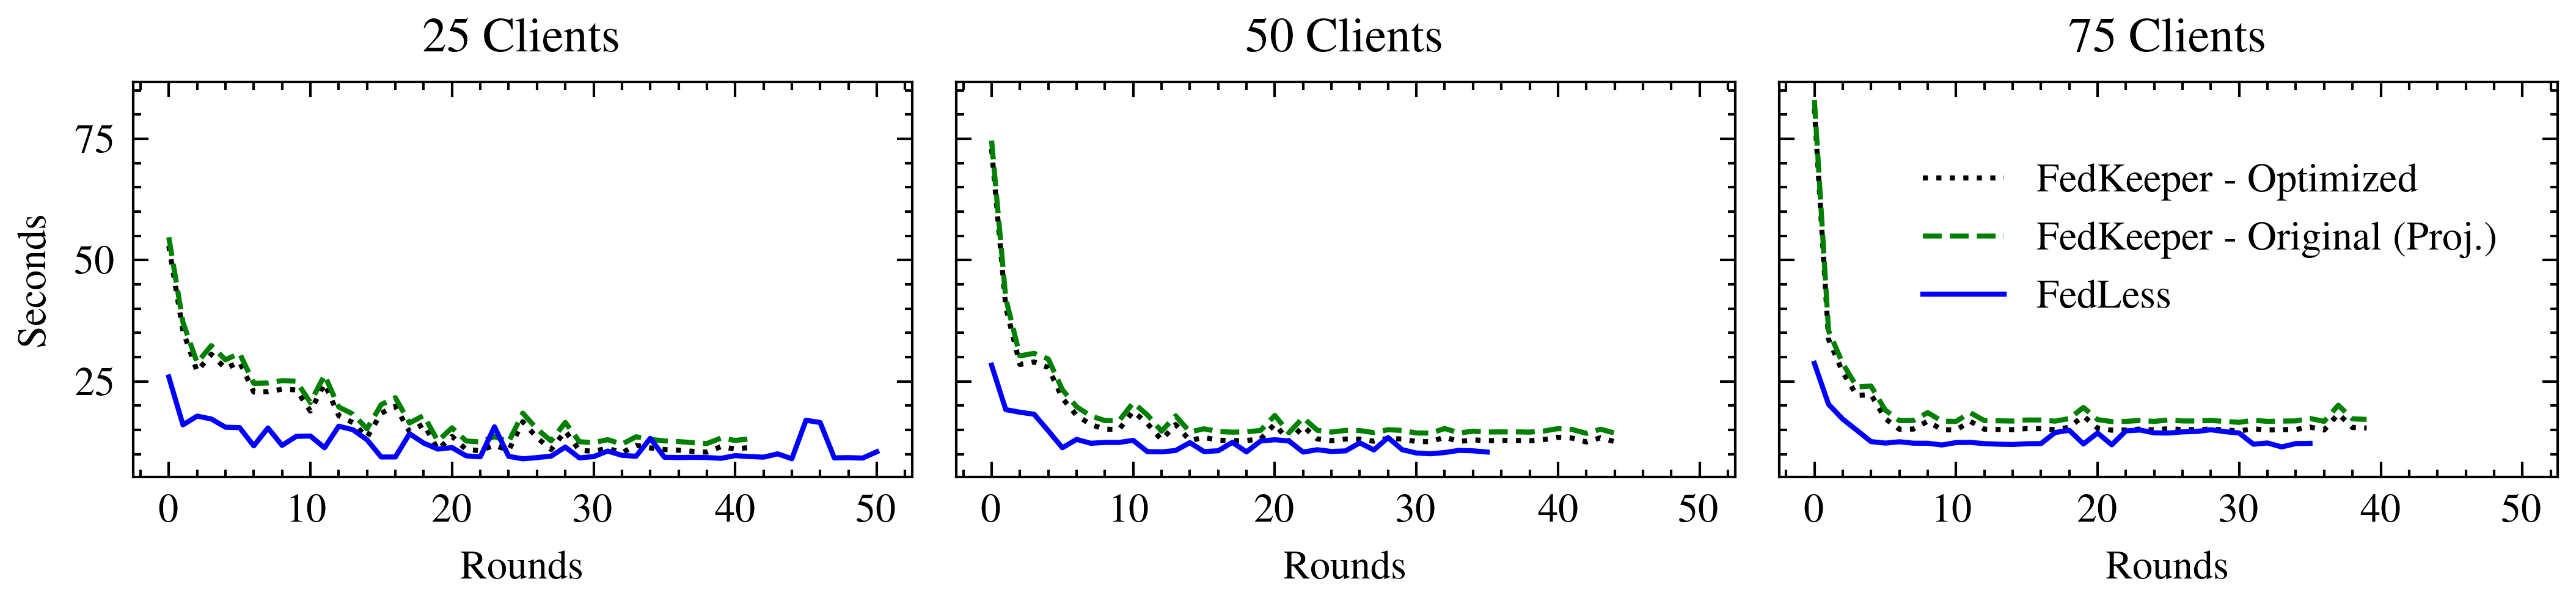

In [731]:
plt.clf()
fig, axarr = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(7.167, 7.167 / 4))
for i, clients in enumerate([25, 50, 75]):
    sns.lineplot(
        x="round",
        y="time",
        data=fl_fk_comp_df.loc[("FedKeeper (Optim.)", clients), :],
        ax=axarr[i],
        label="FedKeeper - Optimized"
    )
    sns.lineplot(
        x="round",
        y="time",
        data=fl_fk_comp_df.loc[("FedKeeper (Orig.)", clients), :],
        ax=axarr[i],
        label="FedKeeper - Original (Proj.)"
    )
    sns.lineplot(
        x="round",
        y="time",
        data=fl_fk_comp_df.loc[("FedLess", clients), :],
        ax=axarr[i],
        label="FedLess"
    )
    axarr[i].set_title(f"{clients} Clients")
    axarr[i].set_xlabel("Rounds")
    axarr[i].set_ylabel("Seconds")
    axarr[i].get_legend().remove()
    
handles, labels = axarr[-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc=(0.74, 0.45))
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-fedkeeper-round-durations.pdf", bbox_inches = 'tight', pad_inches = 0)

In [732]:
def mean_std(vals):
    return f"{np.mean(vals).round(1)}$\pm${np.std(vals).round(1)}"
df_ = fl_fk_comp_df.groupby(["method", "clients-round"]).agg({'time': [mean_std]})#[np.mean, np.median, np.std]}).T.round(1)
df_.columns = ["time"]
#print(df_.to_latex())
print(df_.reset_index().pivot(index="clients-round", columns="method").to_latex())

\begin{tabular}{llll}
\toprule
{} & \multicolumn{3}{l}{time} \\
method & FedKeeper (Optim.) & FedKeeper (Orig.) &       FedLess \\
clients-round &                    &                   &               \\
\midrule
25            &       17.2\$\textbackslash pm\$8.6 &      19.0\$\textbackslash pm\$8.6 &  11.9\$\textbackslash pm\$3.4 \\
50            &      16.8\$\textbackslash pm\$10.1 &     18.6\$\textbackslash pm\$10.1 &  12.6\$\textbackslash pm\$3.5 \\
75            &      18.2\$\textbackslash pm\$10.7 &     20.0\$\textbackslash pm\$10.7 &  13.9\$\textbackslash pm\$3.1 \\
\bottomrule
\end{tabular}



## Flower vs FedLess

<Figure size 1980x1500 with 0 Axes>

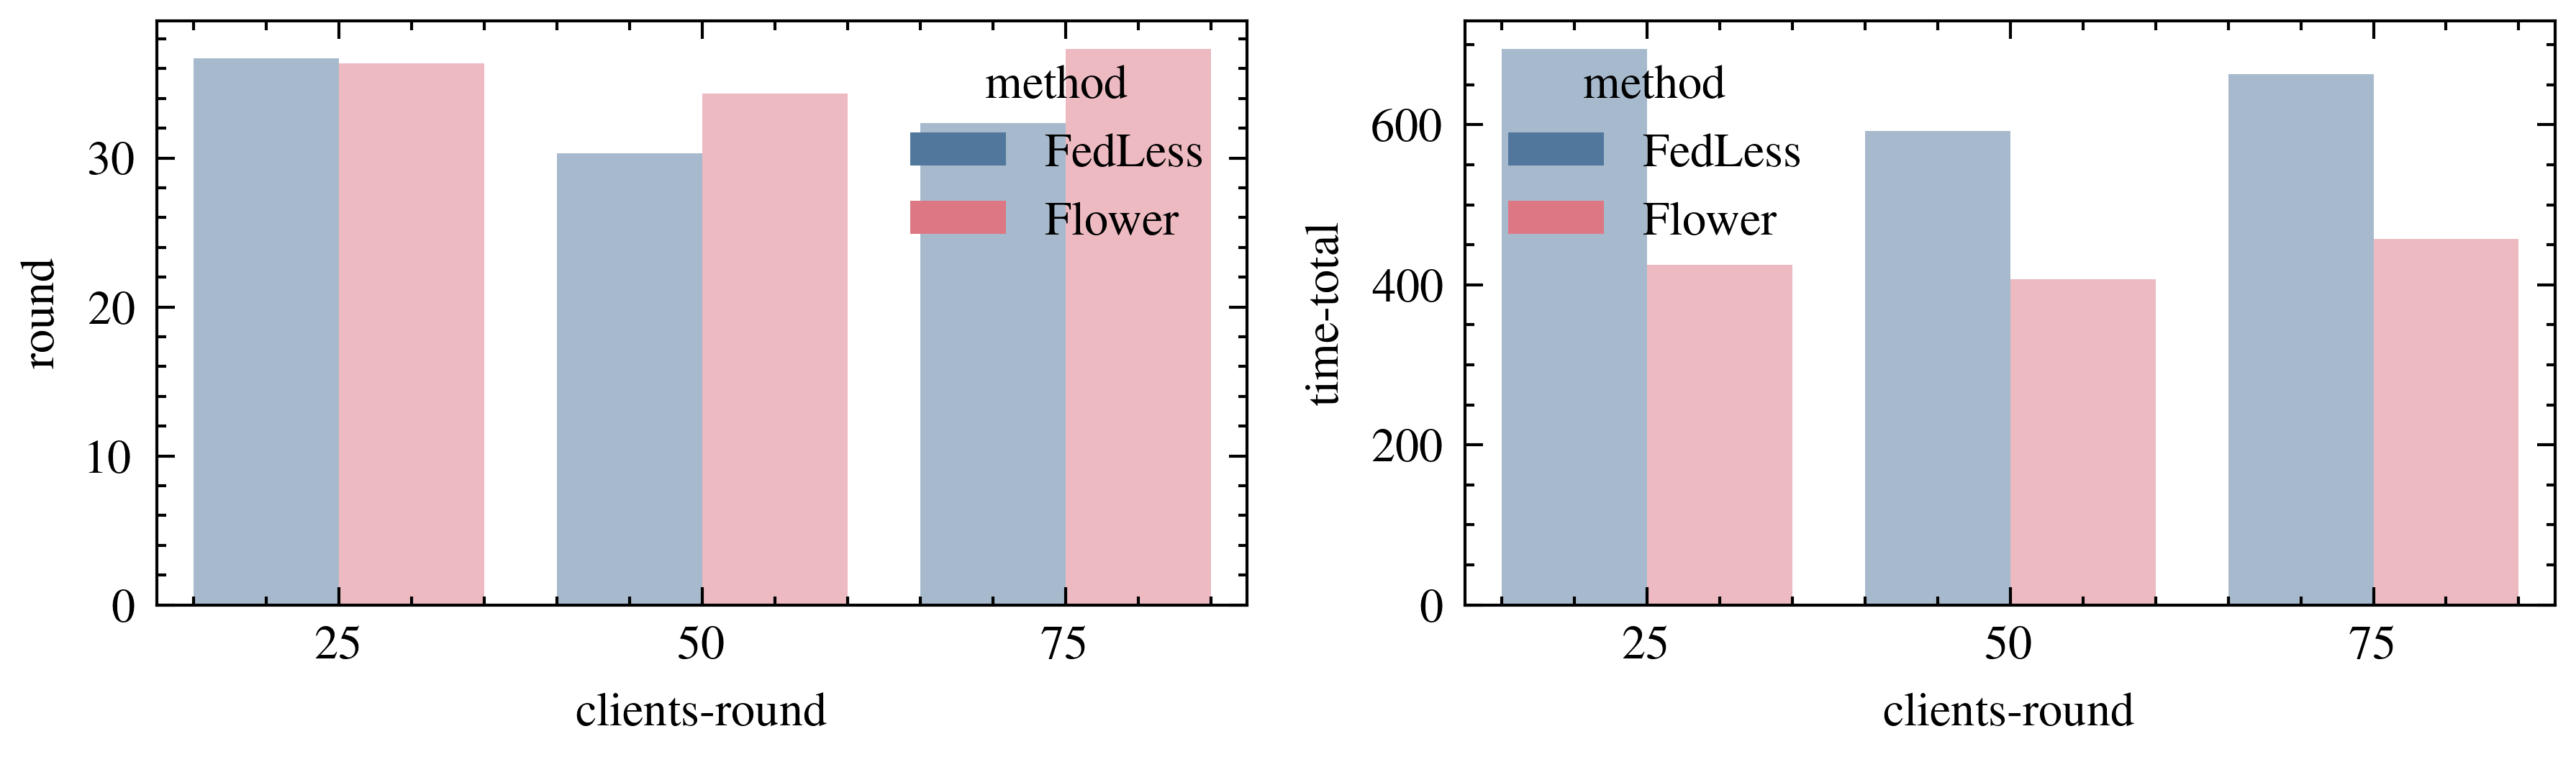

In [106]:

flower_fedless_df = pd.concat([
        flower_df.loc[(("mnist", "femnist"), slice(1, 100), 100, 5, 10), :].reset_index(),
        fedless_flower_df.loc[(("mnist", "femnist"), slice(1, 100), 100, 5, 10, 1), :].reset_index()
    ],
    keys=["Flower", "FedLess"],
    names=["method"]
)
flower_fedless_df = flower_fedless_df[flower_fedless_df["clients-round"] >= 25]
flower_fedless_df["time-total"] = flower_fedless_df.groupby(["method", "dataset", "clients-round", "seed"])["time"].transform(pd.Series.cumsum)
#flower_fedless_df.loc["Flower"["time-clients-est"] = flower_fedless_df["time"] - flower_fedless_df["time-aggregation"] - (flower_fedless_df["time-eval"])

flower_fedless_mnist_df = flower_fedless_df[flower_fedless_df["dataset"] == "mnist"]
flower_fedless_femnist_df = flower_fedless_df[flower_fedless_df["dataset"] == "femnist"]

df_ = flower_fedless_mnist_df.copy().reset_index()
df_ = df_[df_["accuracy"] > 0.99]
df_ = df_.groupby(["method", "dataset", "clients-round", "seed"]).min("round").groupby(["method", "dataset", "clients-round"]).mean().reset_index()
df_

plt.clf()
fig, axarr = plt.subplots(ncols=2, figsize=(7.167, 7.167 / 4), sharex=True, sharey=False)
with plt.style.context(['science', 'ieee', 'bright']):
    sns.barplot(
        x="clients-round",
        y="round",
        hue="method",
        data=df_,
        ax=axarr[0],
    )
    
    sns.barplot(
        x="clients-round",
        y="time-total",
        hue="method",
        data=df_,
        ax=axarr[1]
    )
for bar in [c for b in axarr[1].containers for c in b]:
    bar.set_alpha(0.5)
for bar in [c for b in axarr[0].containers for c in b]:
    bar.set_alpha(0.5)
    
#for i, clients in enumerate([25, 50, 75]):
    #df_ = flower_fedless_df.copy()
    ##df_ = df_[df_["clients-round"] == clients]
    #sns.lineplot(
    #    x="round",
    #    y="accuracy",
    #    hue="method",
    #    data=df_,
    #    ax=axarr[i]
    #)

### Timing Comparison

In [123]:
flower_fedless_mnist_df = flower_fedless_mnist_df.copy()
flower_fedless_mnist_df["time-clients"] = flower_fedless_mnist_df["time"] - flower_fedless_mnist_df["time-aggregation"]


df_ = flower_fedless_femnist_df.groupby(["method"]).mean() # "clients-round"
print("=" * 30)
print(f"Femnist (Median)")
print(df_["time-clients"])
print("=" * 30)

df_ = flower_fedless_mnist_df.groupby(["method"]).mean() # "clients-round"
print("=" * 30)
print(f"Mnist (Median)")
print(df_["time-clients"])
print("=" * 30)

#df_ = flower_fedless_femnist_df.groupby(["method"]).median() # "clients-round"
#print("=" * 30)
#print(f"Femnist (Median) est")
#print(df_["time-clients-est"])
#print("=" * 30)
#
#df_ = flower_fedless_mnist_df.groupby(["method"]).median() # "clients-round"
#print("=" * 30)
#print(f"Mnist (Median) est")
#print(df_["time-clients-est"])
#print("=" * 30)


df_ = flower_fedless_femnist_df.groupby(["method"]).mean() # "clients-round"
print("=" * 30)
print(f"Femnist")
print((df_.loc["FedLess"] / df_.loc["Flower"])[["time", "time-aggregation", "time-clients"]])
print("=" * 30)

df_ = flower_fedless_mnist_df.groupby(["method"]).mean() # "clients-round"
print("=" * 30)
print(f"Mnist")
print((df_.loc["FedLess"] / df_.loc["Flower"])[["time", "time-aggregation", "time-clients"]])
print("=" * 30)

Femnist (Median)
method
Flower     16.822976
FedLess    24.857759
Name: time-clients, dtype: float64
Mnist (Median)
method
Flower      6.219653
FedLess    11.211050
Name: time-clients, dtype: float64
Femnist
time                1.713775
time-aggregation    1.766569
time-clients        1.477608
dtype: float64
Mnist
time                1.630026
time-aggregation    1.433975
time-clients        1.802520
dtype: float64


level_1  clients-total  local-epochs  \
method  dataset clients-round                                            
FedLess mnist   25             417.333333          100.0           5.0   
                50             515.666667          100.0           5.0   
                75             610.000000          100.0           5.0   
Flower  mnist   25             135.333333          100.0           5.0   
                50             433.333333          100.0           5.0   
                75             736.333333          100.0           5.0   

                               batch-size      round  accuracy      loss  \
method  dataset clients-round                                              
FedLess mnist   25                   10.0  36.666667  0.990467  0.034275   
                50                   10.0  30.333333  0.990133  0.032517   
                75                   10.0  32.333333  0.990200  0.032728   
Flower  mnist   25                   10.0  36.333333  0.990033  0.030274   
                50                   10.0  34.333333  0.990100  0.029115   
                75                   10.0  37.333333  0.990000  0.031070   

                                    time  time-eval  time-aggregation  \
method  dataset clients-round                                           
FedLess mnist   25             20.129378        NaN          8.626151   
                50             17.807932        NaN          7.081720   
                75             19.331657        NaN          7.931845   
Flower  mnist   25             10.709507        NaN          5.170000   
                50             11.027628        NaN          5.250000   
                75             11.671908        NaN          5.465000   

                               time-clients  time-total   lr  clients  
method  dataset clients-round                                          
FedLess mnist   25                11.503227  695.025172  1.0     25.0  
                50                10.726212  592.105997  1.0     50.0  
                75                11.399811  663.157374  1.0     75.0  
Flower  mnist   25                 5.393931  424.801238  NaN      NaN  
                50                 5.613349  406.773056  NaN      NaN  
                75                 6.121233  457.210475  NaN      NaN

75 1.4509843232203126 1.9979892814199949


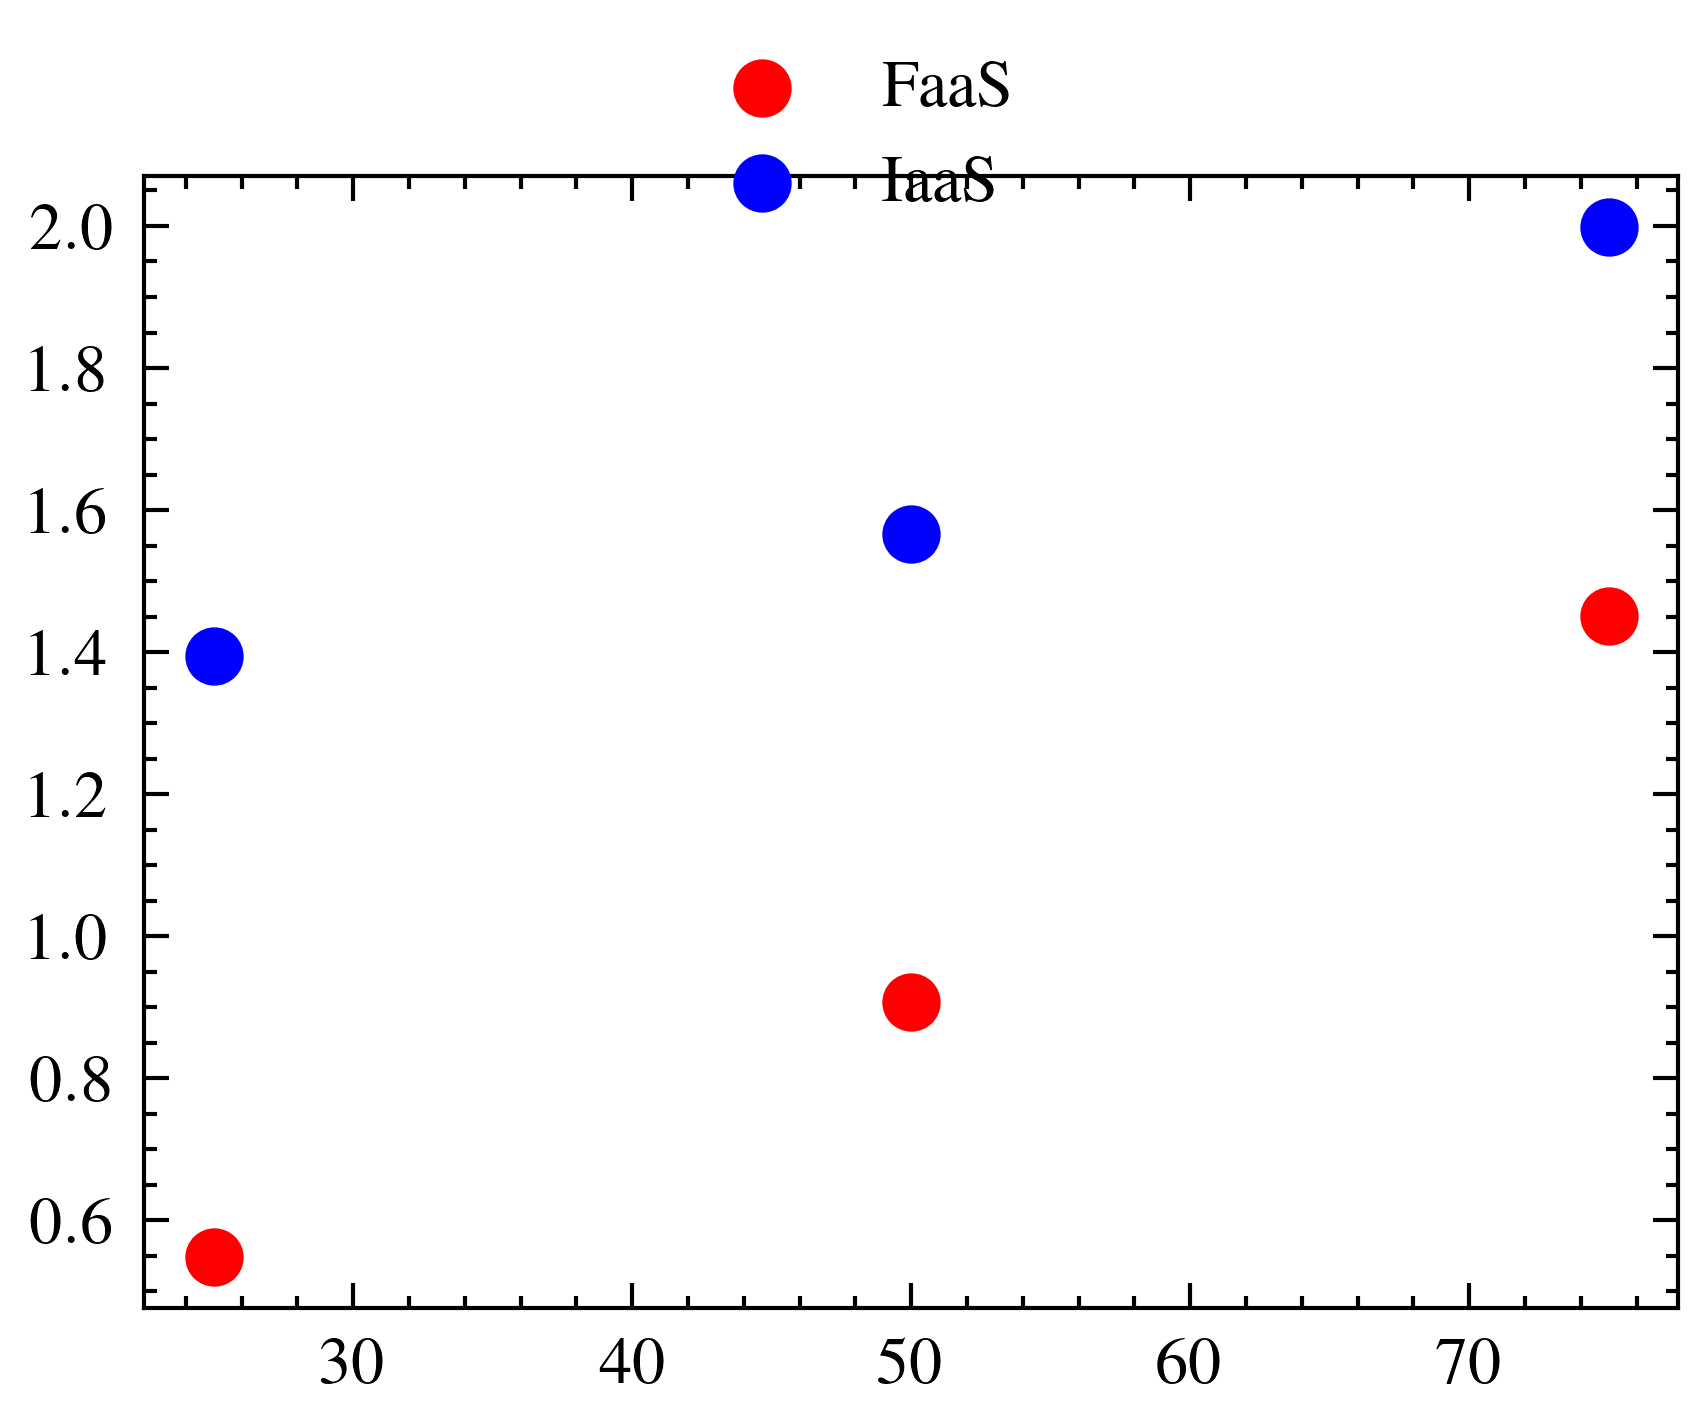

In [185]:
# Pricing
from plot_utils import GCLOUD_FUNCTION_TIERS, calc_gcloud_function_cost, calc_lambda_function_cost
from fedless.benchmark.fedkeeper import create_mnist_cnn
from fedless.benchmark.leaf import create_femnist_cnn
from fedless.serialization import NpzWeightsSerializer

def calc_glcoud_n2_cost(
    invocations_total: int,
    instances: int,
    instance_runtime: float,
    function_egress_mb: float,
):
    # e2-standard-2 	2 	8GB 	$0.086334  per hour
    # n2-standard-2 	2 	8GB 	$0.097118
    NETWORKING_UNIT_PRICE = 0.12

    egress_cost = (invocations_total * function_egress_mb / 1024) * NETWORKING_UNIT_PRICE
    instance_cost = instances * (instance_runtime / 3600) * 0.097118
    return instance_cost + egress_cost



model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_mnist_cnn().get_weights())) / 10**6
memory, cpu_ghz, _ = 2048, 2.4, 2.9e-06
gcloud_cost = calc_gcloud_function_cost(
                        memory=memory, 
                        cpu_ghz=cpu_ghz,
                        invocations=33 * 25,
                        function_runtime_seconds=11.202967,
                        function_egress_mb=model_size,
                        substract_free_tier=False)
iaas_cost = calc_glcoud_n2_cost(
    function_egress_mb=model_size,
    invocations_total=33 * 25,
    instances=100,
    instance_runtime=424.801238
)

df_ = flower_fedless_mnist_df.copy().reset_index()
df_ = df_[df_["accuracy"] > 0.99]
df_ = df_.groupby(["method", "dataset", "clients-round", "seed"]).min("round").groupby(["method", "dataset", "clients-round"]).mean().reset_index()
df_ = df_[df_["dataset"] == "mnist"]
df_ = df_.set_index(["clients-round", "method"])


fig, ax = plt.subplots()

client_list, faas_cost_list, iaas_cost_list = [], [], []
for clients, group in df_.groupby(["clients-round"]):
    #print(group)
    fedless_rounds = group.loc[(clients, "FedLess"), :]["round"]
    flower_rounds = group.loc[(clients, "Flower"), :]["round"]
    flower_runtime = group.loc[(clients, "Flower"), :]["time-total"]
    faas_cost = calc_gcloud_function_cost(
                        memory=memory, 
                        cpu_ghz=cpu_ghz,
                        invocations=fedless_rounds * clients,
                        function_runtime_seconds=11.202967,
                        function_egress_mb=model_size,
                        substract_free_tier=False)
    iaas_cost = calc_glcoud_n2_cost(
        function_egress_mb=model_size,
        invocations_total=flower_rounds * clients,
        instances=100,
        instance_runtime=flower_runtime
    )
    client_list.append(clients)
    faas_cost_list.append(faas_cost)
    iaas_cost_list.append(iaas_cost)
    
ax.scatter(client_list, faas_cost_list, label="FaaS", c="r")
ax.scatter(client_list, iaas_cost_list, label="IaaS", c="b")
    
handles, labels = ax.get_legend_handles_labels()
#ax.get_legend().remove()
print(clients, faas_cost, iaas_cost)
fig.legend(loc="upper center")


25 1.0258180495871094 1.176794139299479
25 1.0258180495871094 1.176794139299479
50 1.9848386447824997 1.6691856957262732
50 1.9848386447824997 1.6691856957262732
75 2.9581729802046874 2.6912110534207176
75 2.9581729802046874 2.6912110534207176


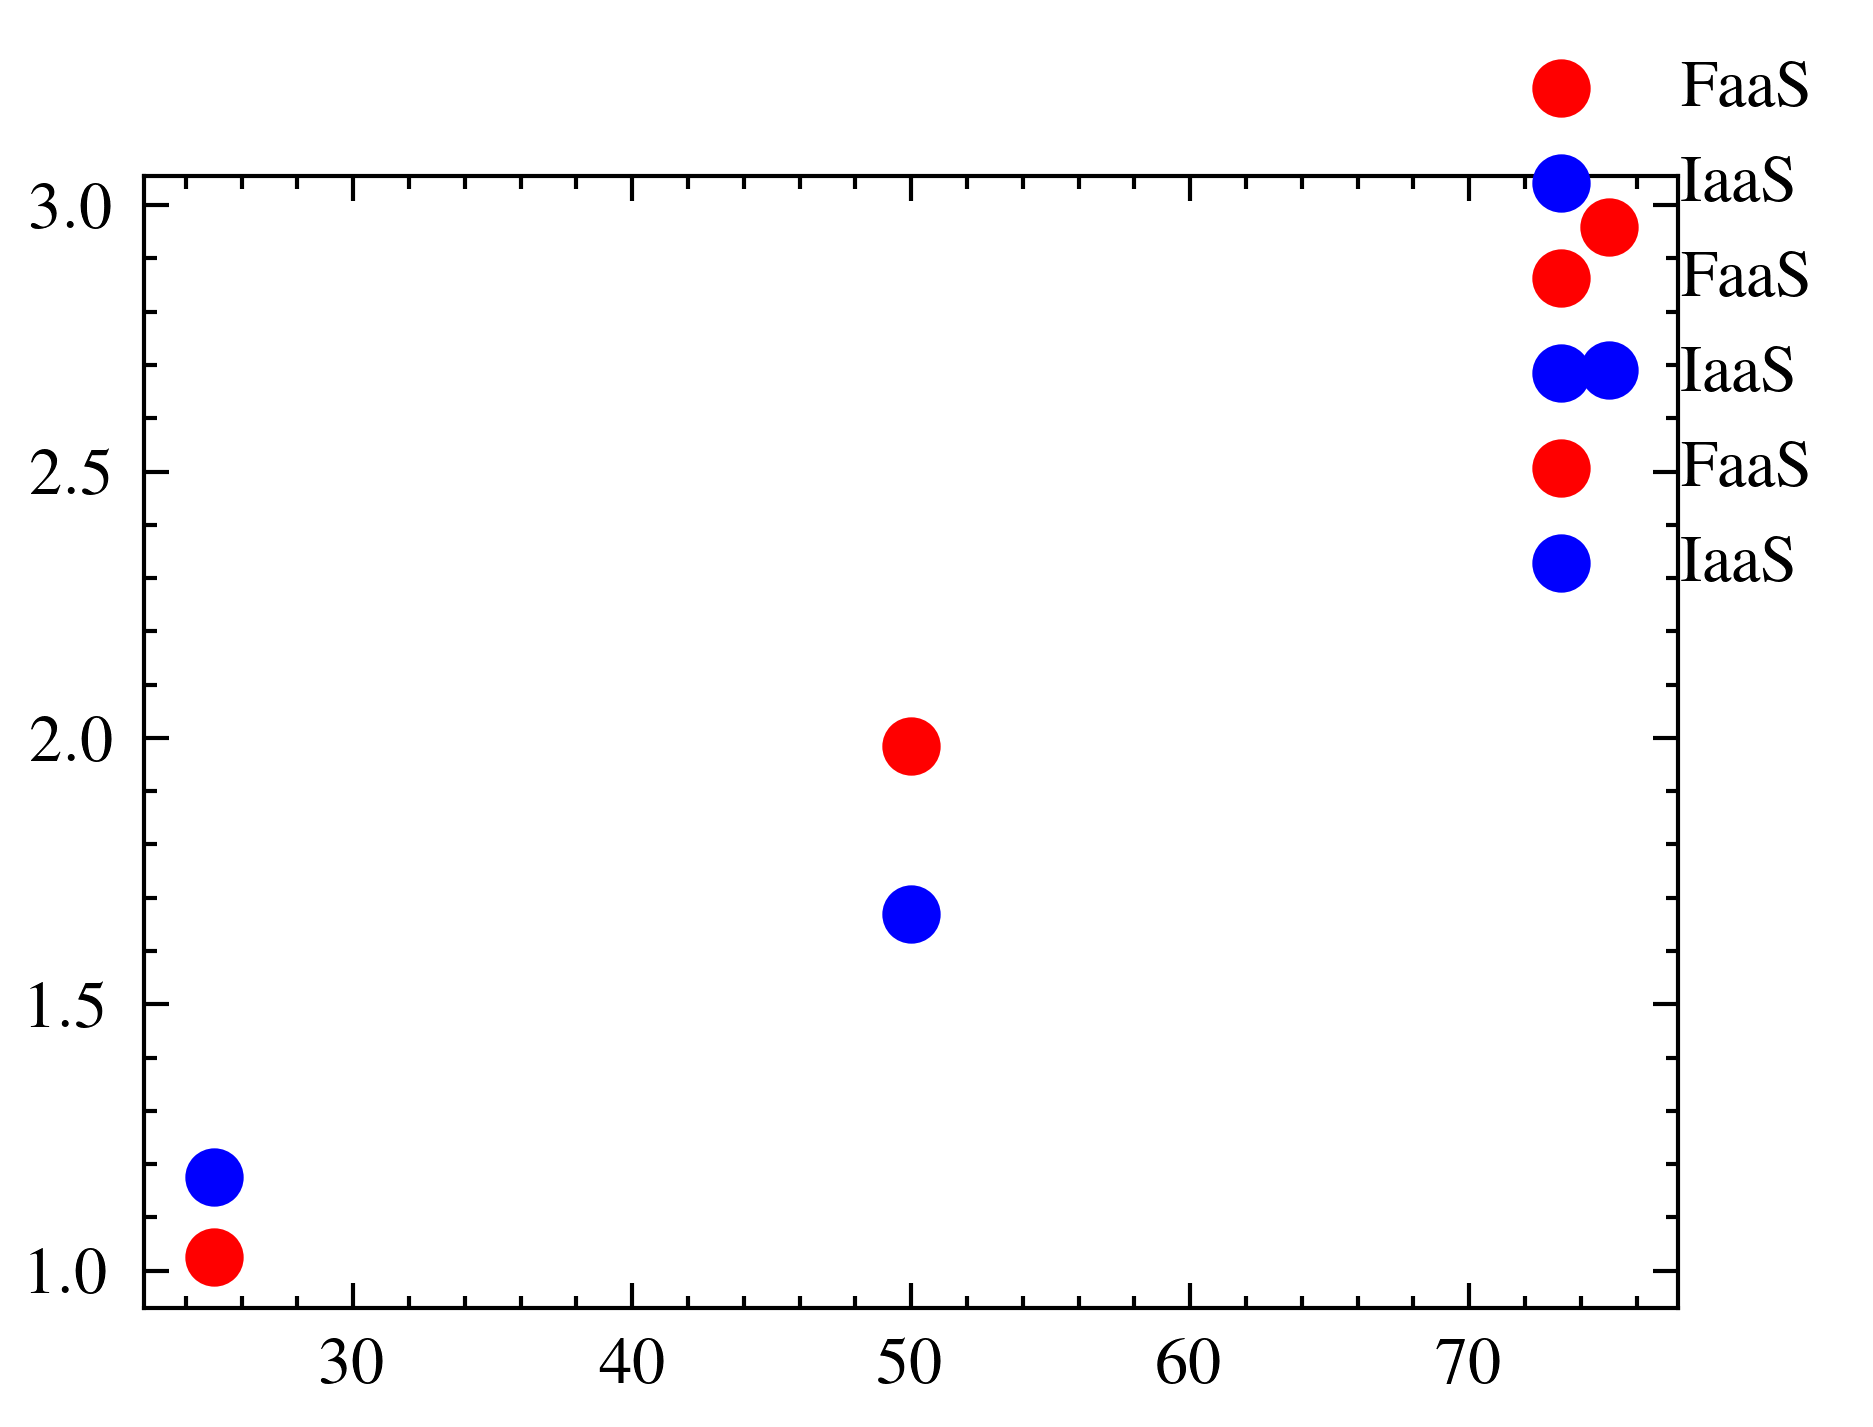

In [176]:
model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_femnist_cnn().get_weights())) / 10**6
df_ = flower_fedless_femnist_df.copy().reset_index()
df_ = df_[df_["accuracy"] > 0.7]
df_ = df_.groupby(["method", "dataset", "clients-round", "seed"]).min("round").groupby(["method", "dataset", "clients-round"]).mean().reset_index()
df_ = df_.set_index(["clients-round", "method"])

fig, ax = plt.subplots()

for clients, group in df_.groupby(["clients-round"]):
    #print(group)
    fedless_rounds = group.loc[(clients, "FedLess"), :]["round"]
    flower_rounds = group.loc[(clients, "Flower"), :]["round"]
    flower_runtime = group.loc[(clients, "Flower"), :]["time-total"]
    
    #fedless_rounds = flower_rounds
    
    faas_cost = calc_gcloud_function_cost(
                        memory=memory, 
                        cpu_ghz=cpu_ghz,
                        invocations=fedless_rounds * clients,
                        function_runtime_seconds=24.857759,
                        function_egress_mb=model_size,
                        substract_free_tier=False)
    iaas_cost = calc_glcoud_n2_cost(
        function_egress_mb=model_size,
        invocations_total=flower_rounds * clients,
        instances=100,
        instance_runtime=flower_runtime
    )
    print(clients, faas_cost, iaas_cost)
    
    
    ax.scatter(clients, faas_cost, label="FaaS", c="r")
    ax.scatter(clients, iaas_cost, label="IaaS", c="b")
    
    print(clients, faas_cost, iaas_cost)
fig.legend()

In [ ]:
model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_mnist_cnn().get_weights())) / 10**6
instance_runtime_orig = flwr_df_.groupby("seed").max("time_since_start").median()["time_since_start"]


x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#line, = ax.plot(x, np.sin(x))



def f(clients_per_round, clients_total):
    #selem = disk(int(Median_Size))
    #with warnings.catch_warnings():
    #    warnings.simplefilter("ignore")
    #    img_median = rank.median(img_gray, selem=selem) 
    
    n_clients_per_round = clients_per_round
    n_rounds = 5000 / n_clients_per_round
    n_instances = clients_total
    n_invocations = n_rounds * n_clients_per_round 
    instance_runtime = instance_runtime_orig / ((n_clients_per_round) / 75) # 3600 / n_clients_per_round


    #ax_neu.imshow(img_median, cmap="gray")
    iaas = []
    faas = []
    
    for n_invocations in range(1, 10000, 100) :
        # 8192MB 	4.8 GHz 	$0.000006800
        memory, cpu_ghz, _ = 2048, 2.4, 2.9e-06
        #memory, cpu_ghz, _ = 8192, 4.8, 2.9e-06
        faas_cost = calc_gcloud_function_cost(
                                memory=memory, 
                                cpu_ghz=cpu_ghz,
                                invocations=n_invocations,
                                function_runtime_seconds=7.062003,
                                function_egress_mb=model_size,
                                substract_free_tier=False)

        # Gcloud Instance
        # e2-standard-2 	2 	8GB 	$0.086334  per hour
        # n2-standard-2 	2 	8GB 	$0.097118
        NETWORKING_UNIT_PRICE = 0.12

        egress_cost = (n_invocations * model_size / 1024) * NETWORKING_UNIT_PRICE
        instance_cost = n_instances * (instance_runtime / 3600) * 0.097118
        iaas_cost = instance_cost + egress_cost
        faas.append(faas_cost)
        iaas.append(iaas_cost)
        #print(instance_cost, egress_cost)
        #print(f"IaaS Cost: {iaas_cost}")
        #print(f"FaaS Cost: {faas_cost}")
    faas = np.array(faas)
    iaas = np.array(iaas)
    break_even_point = np.abs(faas - iaas).argmin() * 100
    print(f"break_even_point: {break_even_point}, {break_even_point / n_clients_per_round} for {n_clients_per_round} clients per round")
    #[l.remove() for l in ax.lines]
    #if ax.get_legend():
    #    ax.get_legend().remove()
    ax.clear()
    ax.vlines(break_even_point, linestyles='dashed', color="red", ymin=np.min(faas), ymax=np.max(faas))
    ax.plot(list(range(1, 10000, 100)), faas, label="FaaS")
    ax.plot(list(range(1, 10000, 100)), iaas, label="IaaS")
    ax.legend()
    